Bachelor thesis Data Mining
Bielefeld University
Lukas Wüppelmann

## Data set
The file `partial_credit_data` contains Data of of students and tasks where every column represents a student and every row a task with possible point range [0,3]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# our data set models a fictional class of students completing a
# number of tasks and is samples from a ground truth 2-PL IRT model
# BUT with a twist, namely that the ground truth ability is actually
# two-dimensional, not uni-dimensional. Still, the abilities are
# correlated, so that a uni-dimensional construct can cover the data
# quite well.

N = 150

# here is our Q matrix
Q = np.array([
   [2., 0.],
   [0., 2.],
   [1., 0.2],
   [0.2, 1.],
   [1., 0.5],
   [0.5, 1.],
   [1., 1.]
])

# here our difficulties for each achievable point value
B = np.array([
   [-1., 0., 2.],
   [-1., 0., 2.],
   [-1, 0.5, 1.5],
   [-1, 0.5, 1.5],
   [0.7, 1., 2.],
   [0.7, 1., 2.],
   [0.5, 1.5, 1.8]
])


A = 4

abilities = np.random.randn(N, 2)

# compute the logit success probabilities of every student on every task
Z = np.zeros((N, B.shape[0], B.shape[1] + 1))
for i in range(N):
   Z[i, :, 1:] = (np.expand_dims(np.dot(abilities[i, :], Q.T), 1) - B) * A

Z = np.cumsum(Z, axis = 2)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 2), 2)

# sample actual data
X = np.zeros((N, B.shape[0]))
for i in range(N):
   for j in range(B.shape[0]):
     X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)

np.savetxt('partial_credit_data.csv', X, fmt = '%g', delimiter = '\t',
encoding = 'utf-8')

C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\182325389.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

X = np.loadtxt('partial_credit_data.csv', delimiter = '\t', dtype=int)

# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

print("number of students: " + str(N))
print("number of tasks: " + str(m))

[[1 1 1 1 0 0 0]
 [1 1 1 1 0 0 0]
 [3 1 2 1 2 0 1]
 [1 0 0 0 0 0 0]
 [3 3 2 3 2 1 3]
 [0 2 0 1 0 0 0]
 [1 1 1 1 0 0 0]
 [0 2 0 2 0 0 0]
 [3 0 2 0 1 0 0]
 [3 2 2 2 2 2 2]
 [2 2 2 2 2 3 3]
 [0 1 1 1 0 0 0]
 [3 1 2 0 2 0 2]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [3 0 3 1 1 0 1]
 [1 2 1 2 0 2 1]
 [2 1 1 1 0 0 0]
 [3 3 3 3 2 2 3]
 [2 2 3 2 1 1 1]
 [2 3 2 3 2 3 3]
 [0 1 1 1 0 0 0]
 [3 0 2 0 0 0 0]
 [0 2 0 1 0 0 0]
 [1 1 2 1 0 0 0]
 [2 0 1 0 0 0 0]
 [1 3 1 3 0 2 0]
 [2 2 1 1 0 0 0]
 [2 2 1 1 1 1 1]
 [1 0 1 1 0 0 0]
 [2 1 1 1 0 1 0]
 [0 3 1 3 0 2 1]
 [0 1 0 0 0 0 0]
 [2 2 1 2 2 2 1]
 [1 0 1 0 0 0 0]
 [0 2 1 2 0 2 1]
 [3 2 3 2 3 2 3]
 [3 3 3 2 3 3 3]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]
 [2 0 1 1 0 0 0]
 [2 2 2 2 2 0 0]
 [2 0 1 0 0 0 0]
 [0 2 0 1 0 0 0]
 [1 0 1 0 0 0 0]
 [3 0 2 1 3 1 1]
 [0 2 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [2 2 1 2 0 2 1]
 [0 2 1 1 0 1 0]
 [2 0 2 1 0 0 0]
 [1 3 1 3 1 2 2]
 [0 2 1 2 0 0 0]
 [3 3 2 3 3 2 3]
 [2 2 2 2 1 2 1]
 [0 3 0 2 0 2 0]
 [2 3 2 3 2 3 

## Pytorch setup

In [5]:
%pip install torch


  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/199.4 MB 17.0 MB/s eta 0:00:12
   ---------------------------------------- 2.1/199.4 MB 22.4 MB/s eta 0:00:09
    --------------------------------------- 3.4/199.4 MB 24.1 MB/s eta 0:00:09
    --------------------------------------- 3.7/199.4 MB 19.9 MB/s eta 0:00:10
   - -------------------------------------- 6.0/199.4 MB 25.6 MB/s eta 0:00:08
   - -------------------------------------- 7.3/199.4 MB 25.8 MB/s eta 0:00:08
   - -------------------------------------- 8.6/199.4 MB 26.1 MB/s eta 0:00:08
   - -------------------------------------- 9.9/199.4 MB 26.2 MB/s eta 0:00:08
   -- ------------------------------------- 11.1/199.4 MB 27.3 MB/s eta 0:00:07
   -- ------------------------------------- 12.3/199.4 MB 27.3 MB/s eta 0:00:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import torch

class IRTModel(torch.nn.Module):
    """The initialization method of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set during training.
    learning_rate: float (default = 1E-2)
        The learning rate of our optimizer during training.
    """
    def __init__(self, C = 1000, num_epochs = 1000, learning_rate = 1E-2):
        # We call the torch.nn.Module constructor
        super(IRTModel, self).__init__()
        # Then, we store all hyperparameters as attributes of the model
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Z: torch.tensor
        A matrix where each row represents a student and each column represents a task.
        The entry Z[i, j] represents the logit probability of student i passing task j.
    
    """
    def predict_logits(self, X = None):
        # the logits correspond to the difference of abilities and difficulties.
        # The 'unsqueeze' method transforms the abilities vector from an N-entry
        # vector to an (N, 1)-matrix and the difficulties vector from an m-entry
        # vector to an (1, m)-matrix, such that the difference - thanks to the
        # magic of broadcasting - yields a (N, m) matrix.
        Z = self.abilities_.unsqueeze(1) - self.difficulties_.unsqueeze(0)
        return Z

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Xhat: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry Xhat[i, j] is 1 if the model predicts student i to pass task j and 0
        otherwise.
    
    """
    def predict(self, X = None):
        Z = self.predict_logits()
        Xhat = torch.zeros_like(Z)
        Xhat[Z > 0.] = 1.
        return Xhat.detach().numpy()

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    """
    def fit(self, X):
        # convert the input matrix to a pytorch tensor
        X = torch.tensor(X, dtype=torch.float)
        # initialize our model parameters based on passing rates, meaning:
        # students have higher initial ability if they get more tasks right and
        # items have higher initial difficulty if less students get them right.
        self.abilities_    = torch.nn.Parameter(torch.mean(X, 1).detach() - 0.5)
        self.difficulties_ = torch.nn.Parameter(0.5 - torch.mean(X, 0).detach())
        # initialize optimizer with the right learning rate and regularization strength
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1./self.C_)
        # start training
        for epoch in range(self.num_epochs_):
            # re-set the current gradient to zero
            optimizer.zero_grad()
            # predict the logit passing probabilities for each student-item combination
            # with the current model
            Z = self.predict_logits()
            # compute the loss between predicted and desired answers using the crossentropy loss
            loss = torch.nn.functional.binary_cross_entropy_with_logits(Z, X)
            # report the loss every 100 steps
            if (epoch+1) % 100 == 0:
                print('epoch %d: loss %g' % (epoch+1, loss.item()))
            # compute the gradient
            loss.backward()
            # apply the optimizer
            optimizer.step()
        
        return self

## training

In [83]:
model_pytorch = IRTModel()
model_pytorch.fit(X)
Xhat = model_pytorch.predict(X)
accuracy = np.mean(Xhat == X)
print(f'Accuracy: {accuracy:.2f}')
print(Xhat)


epoch 100: loss -0.901313
epoch 200: loss -1.39042
epoch 300: loss -1.79679
epoch 400: loss -2.14637
epoch 500: loss -2.45288
epoch 600: loss -2.72582
epoch 700: loss -2.97245
epoch 800: loss -3.19838
epoch 900: loss -3.40794
epoch 1000: loss -3.60444
Accuracy: 0.43
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel


# Zielvariable (ordinal)
y = pd.Series(np.random.choice([1, 2, 3], size=n, p=[0.2, 0.5, 0.3]))  # 1: Niedrig, 2: Mittel, 3: Hoch

# One-Hot-Encoding für kategorische Variablen
X = pd.get_dummies(X, columns=['Bildung'], drop_first=True)

# Modell erstellen
model = OrderedModel(y, X, distr='logit')  # 'logit' für logistische Regression
result = model.fit()

# Ergebnisse anzeigen
print(result.summary())


## VAE

### Models

In [2]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories):
        super(VAE, self).__init__()
        self.num_categories = num_categories
        self.n_ = num_latent
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        self.dec2 = torch.nn.Linear(num_neurons, num_inputs)

    def forward(self, X):
        # Encoding
        H_enc = torch.nn.functional.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.n_]
        LogSigma = Mu_and_LogSigma[:, self.n_:]
        # Sampling
        Z = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)
        # Decoding
        H_dec = torch.nn.functional.relu(self.dec1(Z))
        Y = self.dec2(H_dec)
        # Scaling the output to 0-3 range
        Y = torch.sigmoid(Y) * (self.num_categories - 1)
        return Mu, LogSigma, Z, Y

    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        lambda_ = 0.1
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            # Reset the current gradient to zero
            optimizer.zero_grad()
            # Autoencode the data
            Mu, LogSigma, Z, Y = self.forward(X)
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(torch.square(Z))
            neg_log_qzx = torch.sum(LogSigma)
            neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))
            loss = neg_log_pxz + neg_log_pz - neg_log_qzx
            loss_values.append(loss.item())
            # Compute the gradient via backpropagation
            loss.backward()
            # Apply the optimizer
            optimizer.step()
            
        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

class VAE_PC(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories, noise = 0.1, regul = 0.1, monotonic_penalty_parameter = 200, q_penalty_parameter = 100, q_value_penalty_parameter=1):
        super(VAE_PC, self).__init__()
        self.q_value_penalty_parameter = q_value_penalty_parameter
        self.q_penalty_parameter = q_penalty_parameter
        self.monotonic_penalty_parameter = monotonic_penalty_parameter
        self.noise = noise
        self.regul = regul
        self.num_inputs = num_inputs
        self.num_latent = num_latent
        self.num_categories = num_categories
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        #self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        #self.dec2 = torch.nn.Linear(num_latent, num_inputs)
        # Definiere eine Matrix für Diskriminationsparameter (Q)
        self.Q = torch.nn.Parameter(torch.abs(torch.randn(num_latent, num_inputs)))

        # Diskriminationsparameter und Schwellenwerte initialisieren
        self.a = torch.nn.Parameter(torch.ones(num_inputs))  # Diskriminationsparameter
        #self.a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        self.b = torch.nn.Parameter(torch.randn(num_inputs, num_categories - 1))  # Schwellenwerte
        #self.b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing

    def forward(self, X):
        # Encoding
        H_enc = torch.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.num_latent]
        LogSigma = Mu_and_LogSigma[:, self.num_latent:]
        # Sampling
        # eventuell noise parameter 10e-2
        theta = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)*self.noise
        # Decoding
        #H_dec = torch.relu(self.dec1(Z))
        
        #raw_logits = self.dec2(theta)  # Fähigkeitsschätzung
        #nich constrainter layer bis jetzt
        #print(raw_logits)

        #Apply softplus to ensure Q is positive
        #learned_Q = torch.nn.functional.softplus(self.Q)
        
        #Apply ReLU
        #learned_Q = torch.relu(self.Q)

        # Matrix-basiertes Decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrixmultiplikation

        # Initialisiere eine leere Liste für die Logits (logarithmischen Wahrscheinlichkeiten)
        logits = []

        #a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        #b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing
        
        # Schleife über die Anzahl der Inputs (Items im Test)
        for i in range(self.num_inputs):
            # Initialisiere eine leere Liste für die Logits eines einzelnen Items
            item_logits = []
            
            # Schleife über die Kategorien des aktuellen Items
            for k in range(self.num_categories):
                if k == 0:
                    # Für die erste Kategorie (k = 0) setzen wir die Logits auf Null
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Berechne die Logits für die restlichen Kategorien
                    # Die Logits sind kumulativ, d.h., sie basieren auf den vorherigen Logits
                    item_logits.append((raw_logits[:, i] - self.b[i, k-1]) * self.a[i] + item_logits[-1])
            
            # Füge die Logits des aktuellen Items zur Liste hinzu, und stacke sie entlang der letzten Dimension
            logits.append(torch.stack(item_logits, dim=-1))

        # Stacke die Logits aller Items entlang der zweiten Dimension
        logits = torch.stack(logits, dim=1)
        # Wende die Softmax-Funktion auf die Logits an, um die Wahrscheinlichkeitsverteilung über die Kategorien zu erhalten
        Y = torch.softmax(logits, dim=-1)

        # Gib die anderen Variablen und die Wahrscheinlichkeiten zurück
        return Mu, LogSigma, theta, Y
    
    def decode(self, theta):
        # Decoding only
        # Matrix-based decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrix multiplication

        # Initializing an empty list for logits
        logits = []

        # Loop over the number of inputs (tasks)
        for i in range(self.num_inputs):
            # Initializing an empty list for the logits of a single item
            item_logits = []

            # Loop over categories for the current item
            for k in range(self.num_categories):
                if k == 0:
                    # For the first category (k = 0), set logits to zero
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Calculate logits for remaining categories
                    item_logits.append((raw_logits[:, i] - self.b[i, k - 1]) * self.a[i] + item_logits[-1])

            # Add the logits for the current item to the list
            logits.append(torch.stack(item_logits, dim=-1))

        # Stack logits for all items along the second dimension
        logits = torch.stack(logits, dim=1)
        # Apply softmax to logits to get probabilities
        Y = torch.softmax(logits, dim=-1)

        return Y
    
    
        
        """
        logits = []

        for i in range(self.num_inputs):
            item_logits = []
            
            # Neue Berechnung: raw_logits_item repräsentiert den Einfluss der latenten Fähigkeiten
            raw_logits_item = torch.sum(theta * self.a[i], dim=1)
            
            for k in range(self.num_categories):
                if k == 0:
                    item_logits.append(torch.zeros_like(raw_logits_item))
                else:
                    # Berechne die Logits unter Berücksichtigung der Schwellenwerte b
                    item_logits.append((raw_logits_item - self.b[i, k-1]) + item_logits[-1])
            
            logits.append(torch.stack(item_logits, dim=-1))

        logits = torch.stack(logits, dim=1)
        Y = torch.softmax(logits, dim=-1)

        return Mu, LogSigma, theta, Y
        """



    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            Mu, LogSigma, theta, Y = self.forward(X)
            
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(theta ** 2)
            neg_log_qzx = torch.sum(LogSigma)
            
            #X_onehot = F.one_hot(X.long(), num_classes=self.num_categories).float()
            #neg_log_pxz = -torch.sum(X_onehot * torch.log(Y + 1e-10))
            
            # Compute negative log-likelihood without one-hot encoding
            # X is assumed to be integer-encoded
            X_int = X.squeeze().to(torch.long)  # Remove unnecessary dimensions if needed
            # Use torch.gather to select the probabilities corresponding to the true classes
            true_probs = torch.gather(Y, dim=-1, index=X_int.unsqueeze(-1)).squeeze(-1)
            neg_log_pxz = -torch.sum(torch.log(true_probs + 1e-10))  # Adding epsilon to avoid log(0)
            
            
            original_loss = neg_log_pxz + neg_log_pz - neg_log_qzx

            # Monotonicity penalty
            diffs = self.b[:, 1:] - self.b[:, :-1]
            mono_penalty = torch.sum(F.relu(-diffs))

            # Penalize negative values in Q
            q_penalty = torch.sum(F.relu(-self.Q))

            #penalize positive values
            # Penalize positive values in Q
            q_l1_penalty = torch.sum(F.relu(self.Q))  # Bestraft nur positive Werte


            loss = neg_log_pxz + (neg_log_pz - neg_log_qzx) * self.regul + self.monotonic_penalty_parameter * mono_penalty + self.q_penalty_parameter * q_penalty + q_l1_penalty * self.q_value_penalty_parameter
            loss_values.append(loss.item())
            
            loss.backward()
            optimizer.step()

            if (epoch % 100 == 0):
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()


### Generated Data

In [4]:
num_inputs = 7  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 4

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


NameError: name 'VAE' is not defined

C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 3668.677001953125
Epoch 100, Loss: 3001.598388671875
Epoch 200, Loss: 2622.716064453125
Epoch 300, Loss: 2289.829345703125
Epoch 400, Loss: 1984.656494140625
Epoch 500, Loss: 1702.6212158203125
Epoch 600, Loss: 1467.379638671875
Epoch 700, Loss: 1262.758544921875
Epoch 800, Loss: 1113.801025390625
Epoch 900, Loss: 978.32275390625
Epoch 1000, Loss: 839.6386108398438
Epoch 1100, Loss: 744.1881103515625
Epoch 1200, Loss: 689.3116455078125
Epoch 1300, Loss: 636.9521484375
Epoch 1400, Loss: 624.251708984375
Epoch 1500, Loss: 613.41650390625
Epoch 1600, Loss: 602.8176879882812
Epoch 1700, Loss: 592.1857299804688
Epoch 1800, Loss: 586.6438598632812
Epoch 1900, Loss: 574.1793823242188
Epoch 2000, Loss: 564.579833984375
Epoch 2100, Loss: 556.9618530273438
Epoch 2200, Loss: 545.3185424804688
Epoch 2300, Loss: 540.34375
Epoch 2400, Loss: 529.9967651367188
Epoch 2500, Loss: 521.3765258789062
Epoch 2600, Loss: 509.9197082519531
Epoch 2700, Loss: 500.3456726074219
Epoch 2800, Loss: 48

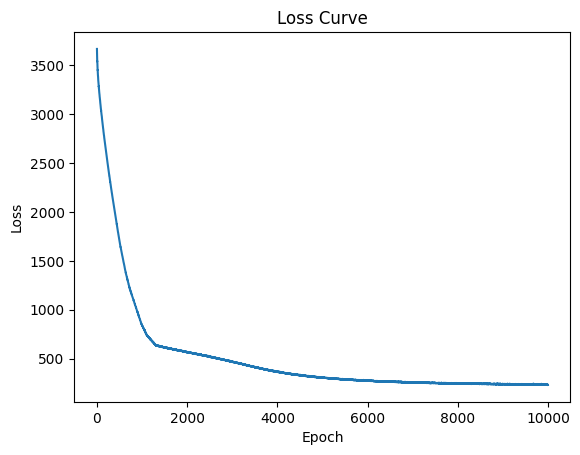

In [23]:
num_inputs = 7  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer


num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=4)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

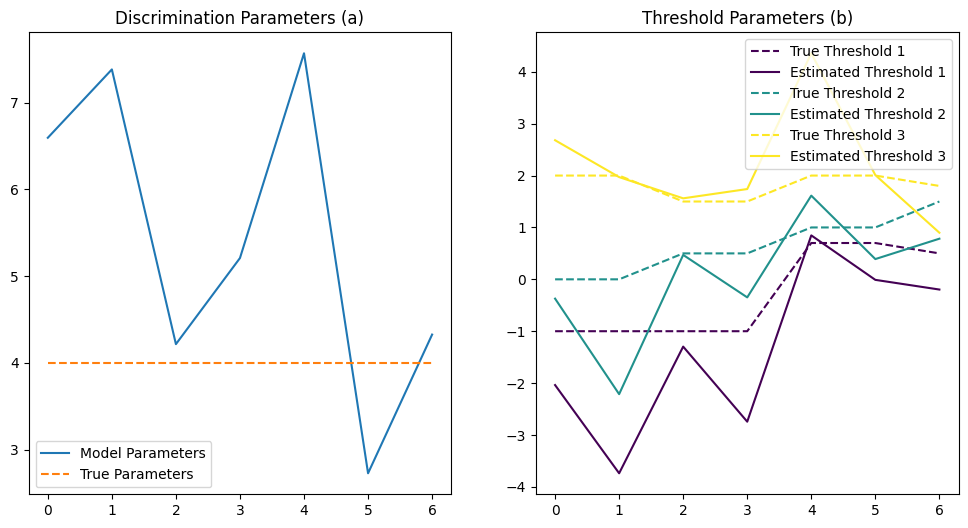

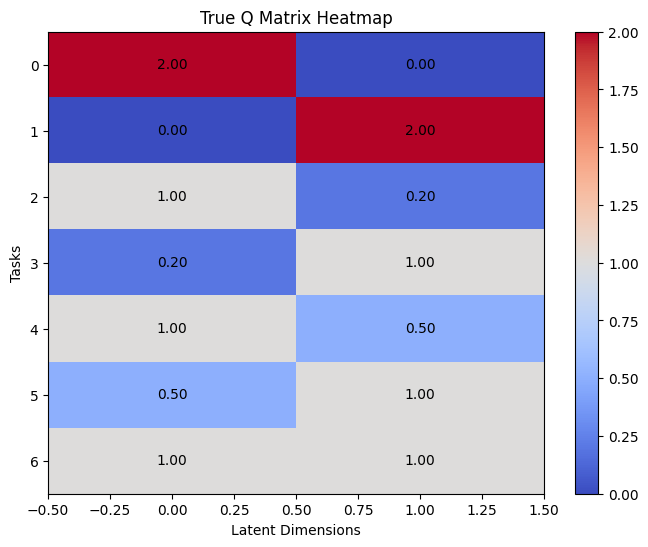

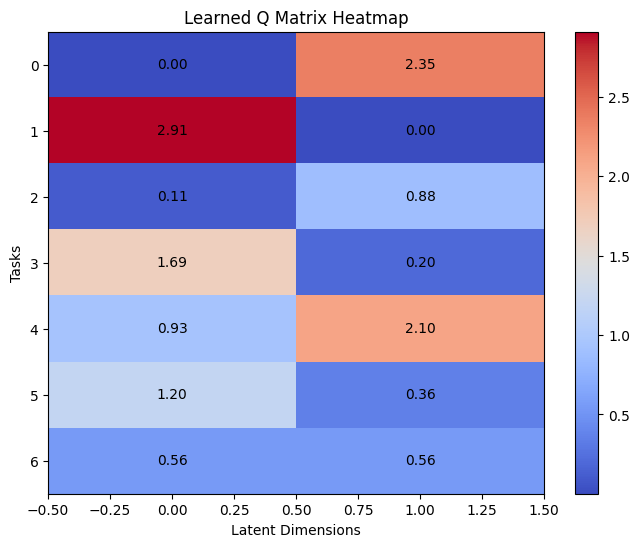

b values:
 [[-2.0377564  -0.3720629   2.680869  ]
 [-3.7380843  -2.2131436   1.9701287 ]
 [-1.2969172   0.4705132   1.5611323 ]
 [-2.7435164  -0.34778196  1.7401737 ]
 [ 0.8470094   1.613021    4.356826  ]
 [-0.01027131  0.39047328  2.0096173 ]
 [-0.19684455  0.78317934  0.898261  ]]
original B values:
 [[-1.   0.   2. ]
 [-1.   0.   2. ]
 [-1.   0.5  1.5]
 [-1.   0.5  1.5]
 [ 0.7  1.   2. ]
 [ 0.7  1.   2. ]
 [ 0.5  1.5  1.8]]
Differences (should be non-negative):
 []
a values (should be positive):
 [6.5962358 7.384333  4.2166843 5.20949   7.5705557 2.727743  4.3270955]
Learned Q matrix:
 [[6.08691422e-04 2.35432458e+00]
 [2.91101766e+00 1.49234873e-03]
 [1.09772086e-01 8.81901503e-01]
 [1.68779767e+00 2.01715812e-01]
 [9.34228599e-01 2.09695625e+00]
 [1.19511104e+00 3.60406309e-01]
 [5.56375742e-01 5.55966496e-01]]
True Q matrix:
 [[2.  0. ]
 [0.  2. ]
 [1.  0.2]
 [0.2 1. ]
 [1.  0.5]
 [0.5 1. ]
 [1.  1. ]]
Difference Q matrix:
 [[-1.99939131  2.35432458]
 [ 2.91101766 -1.99850765]
 

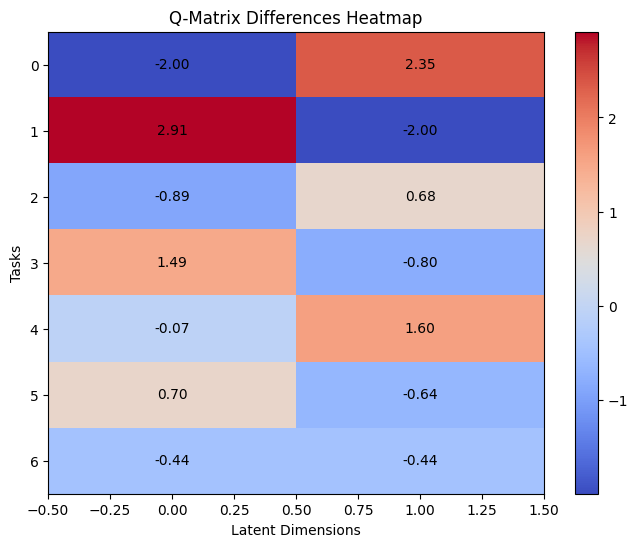

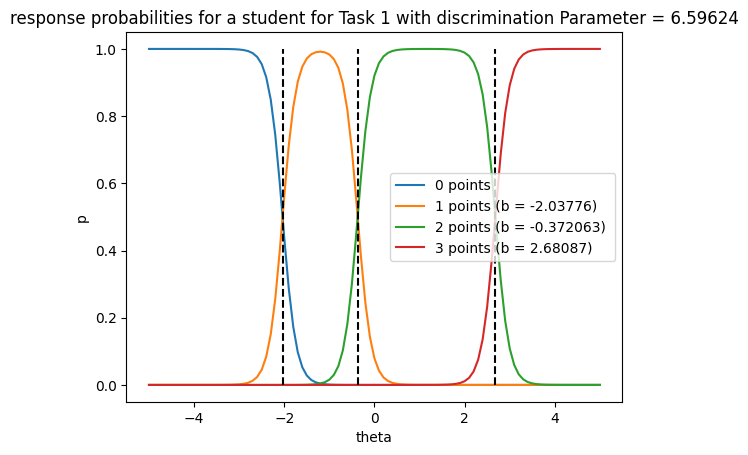

Accuracy: 0.9178571428571428
Mean Absolute Error: 0.08333333333333333
Mean Squared Error: 0.08571428571428572
Quadratic Weighted Kappa: 0.9588633553300114
Validation Accuracy: 0.919047619047619
Validation Mean Absolute Error: 0.08571428571428572
Validation Mean Squared Error: 0.09523809523809523
Validation Quadratic Weighted Kappa: 0.9446348536778275


In [25]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(a_values, label='Model Parameters')
plt.plot([A] * len(a_values), label='True Parameters', linestyle='--')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema


# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(B[:, j], label=f'True Threshold {j + 1}', linestyle='--', color=colors[j])  # Echte Werte
    plt.plot(b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Geschätzte Werte

#plt.plot(b_values, label='Model Parameters')
#plt.plot(B, label='True Parameters', linestyle='--')
plt.legend()

plt.show()

learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T

# Compare the true Q matrix with the learned Q matrix
true_Q = Q

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(Q, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('True Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        plt.text(j, i, f'{Q[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("original B values:\n", B)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)


if learned_Q_transposed.size == true_Q.size:
    diff_Q = learned_Q_transposed - true_Q
    print("Learned Q matrix:\n", learned_Q_transposed)
    print("True Q matrix:\n", true_Q)
    print("Difference Q matrix:\n", diff_Q)

    # Heatmap erstellen
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_Q, cmap='coolwarm', aspect='auto')

    # Colorbar hinzufügen
    plt.colorbar()

    # Achsenbeschriftungen und Titel
    plt.title('Q-Matrix Differences Heatmap')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Tasks')

    # Zahlenwerte in die Heatmap einfügen
    for i in range(diff_Q.shape[0]):
        for j in range(diff_Q.shape[1]):
            plt.text(j, i, f'{diff_Q[i, j]:.2f}', ha='center', va='center', color='black')

    # Heatmap anzeigen
    plt.show()

else:
    print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[theta_val, theta_val]], dtype=torch.float)
        print(theta_tensor)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt
task = 0

theta_values = np.linspace(-5,5, 101)
bs = b_values[task,:]
a  = a_values[task] 

M = len(bs)+1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis = 1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 1), 1)

plt.plot(theta_values, P)
plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a student for Task {task + 1} with discrimination Parameter = %g' % a)
legend_entries = ['0 points ']
for j in range(M-1):
   legend_entries.append('%d points (b = %g) ' % (j+1, bs[j]))
   plt.plot([bs[j], bs[j]], [0, 1], 'k--')
plt.legend(legend_entries)
plt.show()



# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

### Usability Datensatz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('uta4_sus.csv', skip_header=1, delimiter=',')

X = data[:, 3:13].astype(int)
#print(X)
X = X - 1

# Zweite CSV-Datei einlesen und verarbeiten
data2 = np.genfromtxt('uta7_sus_assistant.csv', skip_header=1, delimiter=',')
X2 = data2[:, 3:13].astype(int)
#print(X2)
X2 = X2 - 1  # Anpassung der Werte

# Dritte CSV-Datei einlesen und verarbeiten
data3 = np.genfromtxt('uta7_sus_current.csv', skip_header=1, delimiter=',')
X3 = data3[:, 3:13].astype(int)
X3 = X3 - 1  # Anpassung der Werte

# Vierte CSV-Datei einlesen und verarbeiten
data4 = np.genfromtxt('uta10_SUS_analises.csv', skip_header=1, delimiter=';')
X4 = data4[:, 3:13].astype(int)
X4 = X4 - 1  # Anpassung der Werte

# fünfte CSV-Datei einlesen und verarbeiten
data5 = np.genfromtxt('mimbcdui_UTA9_SUS.csv', skip_header=1, delimiter=',')
X5 = data5[:, 2:12].astype(int)
print(X5)
X5 = X5 - 1  # Anpassung der Werte


# Alle drei Matrizen entlang der Zeilenachse (axis=0) zusammenfügen
X = np.concatenate((X2, X4, X3), axis=0)
#print(X)

# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
#print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))

[[5 1 5 1 4 1 4 1 5 1]
 [4 1 4 1 4 2 5 2 5 1]
 [4 1 4 2 4 2 5 2 4 3]
 [5 1 5 1 5 1 5 1 5 4]
 [4 1 5 1 4 1 4 1 4 1]
 [5 1 5 1 5 1 5 1 5 1]
 [4 2 4 2 2 3 5 5 5 1]
 [3 1 5 4 5 1 5 1 4 3]
 [4 4 4 5 5 1 4 2 5 4]
 [5 1 5 1 5 1 4 1 4 5]
 [2 1 5 1 5 1 1 1 5 5]
 [3 1 5 1 5 1 5 1 5 1]
 [5 2 4 1 5 1 5 1 5 1]
 [5 1 5 1 4 1 4 1 5 1]
 [5 1 4 1 4 1 4 1 5 2]
 [3 1 5 1 5 1 5 1 5 1]
 [4 1 4 1 5 2 3 1 5 1]
 [4 1 5 1 5 1 5 1 5 1]
 [4 2 5 1 4 5 3 2 3 1]
 [1 2 5 1 5 1 4 1 4 2]
 [5 2 5 1 4 2 4 1 4 5]
 [4 3 4 1 5 3 5 1 5 1]
 [2 1 4 1 5 1 4 2 4 2]
 [5 1 5 1 5 1 5 1 5 1]
 [5 1 4 1 5 1 5 1 4 1]
 [5 1 5 1 5 1 5 1 5 1]
 [3 2 4 1 5 1 5 1 3 1]
 [3 1 3 1 5 5 5 1 5 1]
 [5 1 5 5 5 1 5 1 5 3]
 [5 1 5 1 5 1 5 1 5 5]
 [5 1 5 1 5 1 5 1 5 1]]
number of rows: 88
number of columns: 10


C:\Users\wuepp\AppData\Local\Temp\ipykernel_6848\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 5887.5927734375
Epoch 100, Loss: 4965.9521484375
Epoch 200, Loss: 4183.90087890625
Epoch 300, Loss: 3528.614013671875
Epoch 400, Loss: 3056.462646484375
Epoch 500, Loss: 2721.3857421875
Epoch 600, Loss: 2490.08740234375
Epoch 700, Loss: 2296.131103515625
Epoch 800, Loss: 2125.3369140625
Epoch 900, Loss: 1988.681640625
Epoch 1000, Loss: 1857.927001953125
Epoch 1100, Loss: 1739.505126953125
Epoch 1200, Loss: 1649.5118408203125
Epoch 1300, Loss: 1561.97705078125
Epoch 1400, Loss: 1476.592041015625
Epoch 1500, Loss: 1390.56103515625
Epoch 1600, Loss: 1303.105224609375
Epoch 1700, Loss: 1240.7808837890625
Epoch 1800, Loss: 1195.827880859375
Epoch 1900, Loss: 1149.318603515625
Epoch 2000, Loss: 1104.4549560546875
Epoch 2100, Loss: 1060.1014404296875
Epoch 2200, Loss: 1021.0968017578125
Epoch 2300, Loss: 984.2843627929688
Epoch 2400, Loss: 947.0031127929688
Epoch 2500, Loss: 911.8184204101562
Epoch 2600, Loss: 874.0490112304688
Epoch 2700, Loss: 840.0382080078125
Epoch 2800, Lo

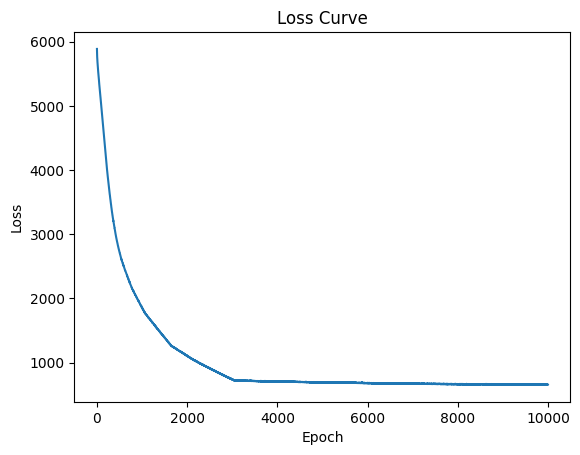

In [39]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

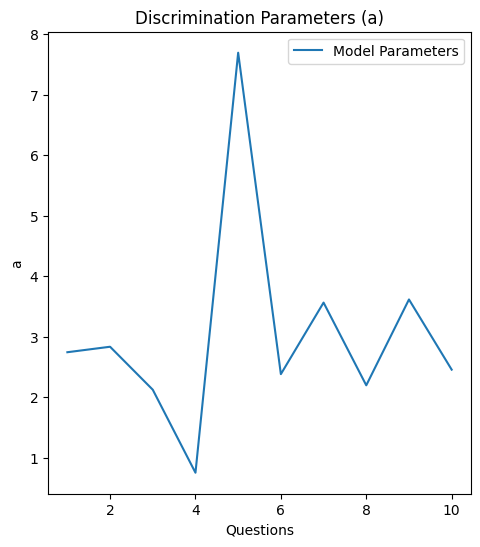

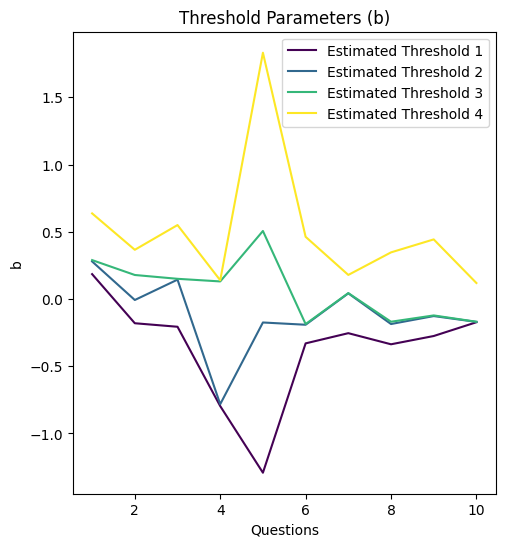

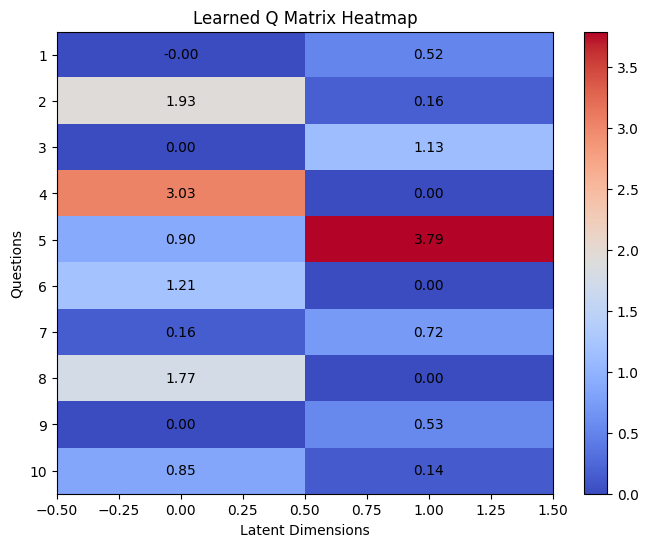

b values:
 [[ 0.18469407  0.27896085  0.28913653  0.6363618 ]
 [-0.18059649 -0.00768275  0.17834747  0.36575153]
 [-0.20677309  0.14364953  0.149903    0.54970497]
 [-0.79688376 -0.7827133   0.13041379  0.13909945]
 [-1.292485   -0.17496923  0.50559664  1.8316269 ]
 [-0.33040506 -0.19180688 -0.18673281  0.46238476]
 [-0.2544838   0.04186311  0.04363398  0.17880577]
 [-0.33714193 -0.18649772 -0.16937454  0.34652513]
 [-0.27559903 -0.12725222 -0.12245895  0.44300058]
 [-0.17308971 -0.17054181 -0.16940778  0.118629  ]]
Differences (should be non-negative):
 []
a values (should be positive):
 [2.7450202  2.8356576  2.1255856  0.75408936 7.6936336  2.3830059
 3.5650954  2.198357   3.6168327  2.4572012 ]
Learned Q matrix:
 [[-1.1263680e-04  5.1634187e-01]
 [ 1.9304969e+00  1.6255827e-01]
 [ 8.0629005e-05  1.1290942e+00]
 [ 3.0348482e+00  2.0323035e-03]
 [ 8.9976531e-01  3.7856474e+00]
 [ 1.2050555e+00  8.2373735e-04]
 [ 1.5742657e-01  7.1790910e-01]
 [ 1.7716268e+00  9.4461226e-04]
 [ 2.3402

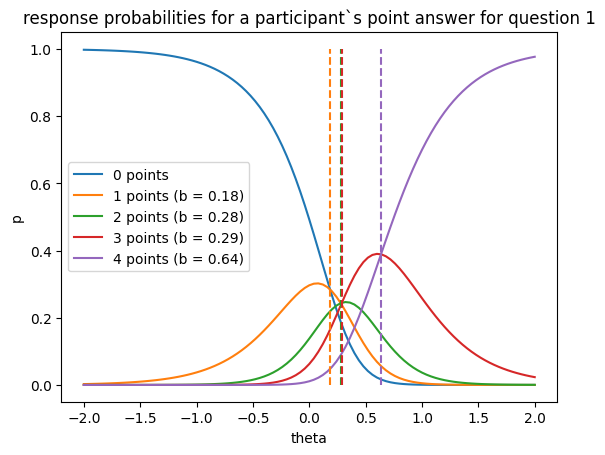

Accuracy: 0.7
Mean Absolute Error: 0.4590909090909091
Mean Squared Error: 0.884090909090909
Quadratic Weighted Kappa: 0.8545238196421742
Validation Accuracy: 0.7090909090909091
Validation Mean Absolute Error: 0.39090909090909093
Validation Mean Squared Error: 0.6727272727272727
Validation Quadratic Weighted Kappa: 0.8928778228141285


In [40]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(np.arange(1, len(a_values) + 1), a_values, label='Model Parameters')  # Shift task index to start from 1
plt.ylabel('a')
plt.xlabel('Questions')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema

plt.figure(figsize=(12, 6))

# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(np.arange(1, len(b_values) + 1), b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Shift task index to start from 1

plt.ylabel('b')
plt.xlabel('Questions')
plt.legend()

plt.show()


learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Questions')

# Set y-ticks to start from 1 instead of 0
plt.yticks(np.arange(learned_Q_transposed.shape[0]), np.arange(1, learned_Q_transposed.shape[0] + 1))

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt

task = 0

theta_values = np.linspace(-2, 2, 101)
bs = b_values[task, :]
a = a_values[task]

M = len(bs) + 1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis=1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis=1), 1)

# Plot the probabilities and store the plot objects
lines = []
for i in range(M):
    line, = plt.plot(theta_values, P[:, i], label=f'{i} points')
    lines.append(line)

plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a participant`s point answer for question {task + 1}')

legend_entries = ['0 points ']
for j in range(M - 1):
    legend_entries.append(f'{j + 1} points (b = {bs[j]:.2f})')

# Plot vertical lines (thresholds) in the same color as the corresponding probabilities
for j in range(M - 1):
    plt.plot([bs[j], bs[j]], [0, 1], linestyle='--', color=lines[j + 1].get_color())  # Use the color of the corresponding probability curve

plt.legend(legend_entries)
plt.show()


# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


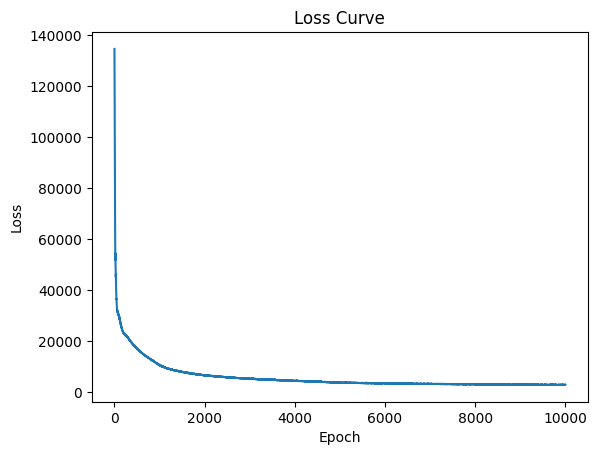

Accuracy: 0.9625
Mean Absolute Error: 0.03750000149011612
Mean Squared Error: 0.03750000149011612
Quadratic Weighted Kappa: 0.9935330832673429
Validation Accuracy: 0.7090909090909091
Validation Mean Absolute Error: 0.3909091055393219
Validation Mean Squared Error: 0.6727272272109985
Validation Quadratic Weighted Kappa: 0.886746250382614


In [78]:
from sklearn.metrics import mean_squared_error
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 5

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#### Cross Validation for model

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 5348.02294921875
Epoch 100, Loss: 4410.65673828125
Epoch 200, Loss: 3797.072998046875
Epoch 300, Loss: 3228.91943359375
Epoch 400, Loss: 2796.72412109375
Epoch 500, Loss: 2448.686279296875
Epoch 600, Loss: 2168.36328125
Epoch 700, Loss: 1926.8564453125
Epoch 800, Loss: 1761.9110107421875
Epoch 900, Loss: 1627.8748779296875
Epoch 1000, Loss: 1498.4547119140625
Epoch 1100, Loss: 1372.4334716796875
Epoch 1200, Loss: 1246.12158203125
Epoch 1300, Loss: 1119.5791015625
Epoch 1400, Loss: 992.4876708984375
Epoch 1500, Loss: 878.1226196289062
Epoch 1600, Loss: 793.3866577148438
Epoch 1700, Loss: 742.7496948242188
Epoch 1800, Loss: 732.27734375
Epoch 1900, Loss: 725.2988891601562
Epoch 2000, Loss: 726.617431640625
Epoch 2100, Loss: 721.3228759765625
Epoch 2200, Loss: 717.7464599609375
Epoch 2300, Loss: 715.71337890625
Epoch 2400, Loss: 710.1168823242188
Epoch 2500, Loss: 710.4429321289062
Epoch 2600, Loss: 709.7876586914062
Epoch 2700, Loss: 709.8742065429688
Epoch 2800, Loss: 705

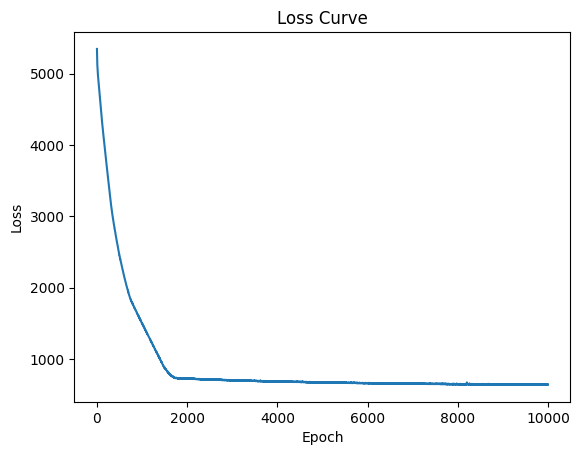

Training Accuracy: 0.7136363636363636
Training Mean Absolute Error: 0.45340909090909093
Training Mean Squared Error: 0.9125000000000002
Training Quadratic Weighted Kappa: 0.8488903715298717
Validation Accuracy: 0.6954545454545454
Validation Mean Absolute Error: 0.39999999999999997
Validation Mean Squared Error: 0.6909090909090908
Validation Quadratic Weighted Kappa: 0.8903951543120854
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 6229.11328125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4760.02001953125
Epoch 200, Loss: 4151.029296875
Epoch 300, Loss: 3571.482666015625
Epoch 400, Loss: 3106.4423828125
Epoch 500, Loss: 2729.4814453125
Epoch 600, Loss: 2409.649169921875
Epoch 700, Loss: 2161.3310546875
Epoch 800, Loss: 1928.5552978515625
Epoch 900, Loss: 1702.6258544921875
Epoch 1000, Loss: 1484.590087890625
Epoch 1100, Loss: 1301.0518798828125
Epoch 1200, Loss: 1184.27880859375
Epoch 1300, Loss: 1109.7320556640625
Epoch 1400, Loss: 1040.6038818359375
Epoch 1500, Loss: 981.1748657226562
Epoch 1600, Loss: 949.2548828125
Epoch 1700, Loss: 913.7110595703125
Epoch 1800, Loss: 879.7340087890625
Epoch 1900, Loss: 852.3153076171875
Epoch 2000, Loss: 816.5216674804688
Epoch 2100, Loss: 782.846435546875
Epoch 2200, Loss: 747.0328979492188
Epoch 2300, Loss: 731.6553955078125
Epoch 2400, Loss: 726.99267578125
Epoch 2500, Loss: 726.1492919921875
Epoch 2600, Loss: 725.8026123046875
Epoch 2700, Loss: 722.1923217773438
Epoch 2800, Loss: 720.8657836914062
Epoch 2900, L

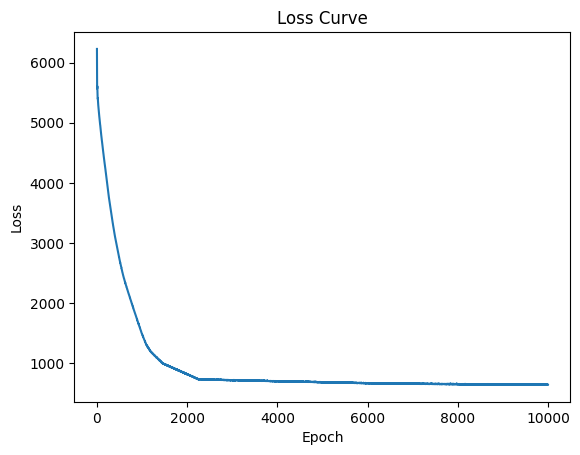

Training Accuracy: 0.7136363636363636
Training Mean Absolute Error: 0.42727272727272725
Training Mean Squared Error: 0.8204545454545455
Training Quadratic Weighted Kappa: 0.8617431298068721
Validation Accuracy: 0.6909090909090909
Validation Mean Absolute Error: 0.45
Validation Mean Squared Error: 0.8681818181818182
Validation Quadratic Weighted Kappa: 0.8696456048046856
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 6031.27294921875


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4747.064453125
Epoch 200, Loss: 4058.362548828125
Epoch 300, Loss: 3390.09423828125
Epoch 400, Loss: 2907.78955078125
Epoch 500, Loss: 2509.641357421875
Epoch 600, Loss: 2191.931640625
Epoch 700, Loss: 1940.89599609375
Epoch 800, Loss: 1722.523681640625
Epoch 900, Loss: 1541.7769775390625
Epoch 1000, Loss: 1427.724853515625
Epoch 1100, Loss: 1315.6109619140625
Epoch 1200, Loss: 1206.2686767578125
Epoch 1300, Loss: 1098.6790771484375
Epoch 1400, Loss: 990.7904052734375
Epoch 1500, Loss: 921.9822998046875
Epoch 1600, Loss: 860.36962890625
Epoch 1700, Loss: 823.2103271484375
Epoch 1800, Loss: 786.3826904296875
Epoch 1900, Loss: 749.0604248046875
Epoch 2000, Loss: 737.4255981445312
Epoch 2100, Loss: 735.00439453125
Epoch 2200, Loss: 731.1314086914062
Epoch 2300, Loss: 727.9387817382812
Epoch 2400, Loss: 724.2762451171875
Epoch 2500, Loss: 723.722412109375
Epoch 2600, Loss: 721.3583374023438
Epoch 2700, Loss: 717.1696166992188
Epoch 2800, Loss: 718.1207275390625
Epoch 2900,

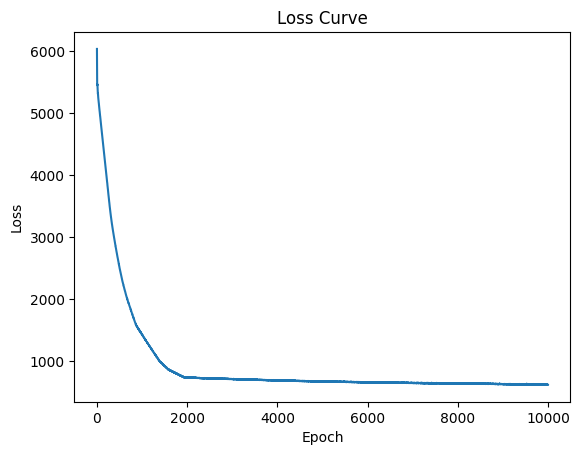

Training Accuracy: 0.6977272727272728
Training Mean Absolute Error: 0.44431818181818183
Training Mean Squared Error: 0.8602272727272726
Training Quadratic Weighted Kappa: 0.8610583890148193
Validation Accuracy: 0.6272727272727273
Validation Mean Absolute Error: 0.5954545454545455
Validation Mean Squared Error: 1.231818181818182
Validation Quadratic Weighted Kappa: 0.7983139833833997
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 5112.83935546875


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4206.40576171875
Epoch 200, Loss: 3552.128173828125
Epoch 300, Loss: 3014.628173828125
Epoch 400, Loss: 2576.4140625
Epoch 500, Loss: 2228.017333984375
Epoch 600, Loss: 1936.956787109375
Epoch 700, Loss: 1658.068603515625
Epoch 800, Loss: 1384.6331787109375
Epoch 900, Loss: 1196.3450927734375
Epoch 1000, Loss: 1081.2706298828125
Epoch 1100, Loss: 978.0634765625
Epoch 1200, Loss: 896.25732421875
Epoch 1300, Loss: 843.4453125
Epoch 1400, Loss: 798.7572021484375
Epoch 1500, Loss: 754.2930908203125
Epoch 1600, Loss: 719.2025756835938
Epoch 1700, Loss: 716.614013671875
Epoch 1800, Loss: 710.21728515625
Epoch 1900, Loss: 710.2494506835938
Epoch 2000, Loss: 706.6944580078125
Epoch 2100, Loss: 704.967041015625
Epoch 2200, Loss: 702.120361328125
Epoch 2300, Loss: 700.8638916015625
Epoch 2400, Loss: 701.3638305664062
Epoch 2500, Loss: 698.4920043945312
Epoch 2600, Loss: 694.7174682617188
Epoch 2700, Loss: 692.0573120117188
Epoch 2800, Loss: 689.5067749023438
Epoch 2900, Loss: 68

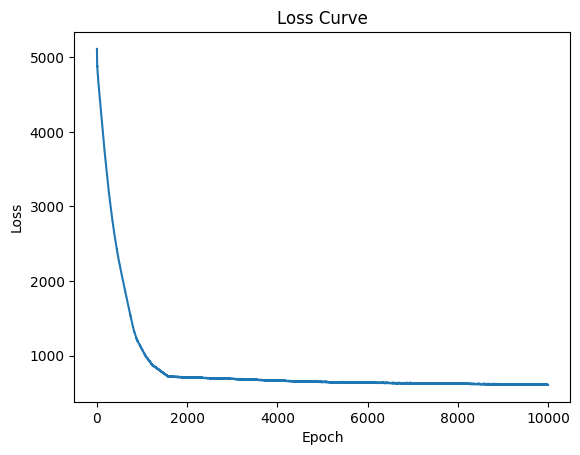

Training Accuracy: 0.7397727272727272
Training Mean Absolute Error: 0.40681818181818186
Training Mean Squared Error: 0.825
Training Quadratic Weighted Kappa: 0.8635291705116375
Validation Accuracy: 0.6227272727272727
Validation Mean Absolute Error: 0.6545454545454545
Validation Mean Squared Error: 1.490909090909091
Validation Quadratic Weighted Kappa: 0.760010642543568
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 5807.0322265625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4715.54296875
Epoch 200, Loss: 3938.685546875
Epoch 300, Loss: 3246.3232421875
Epoch 400, Loss: 2775.315673828125
Epoch 500, Loss: 2412.862060546875
Epoch 600, Loss: 2074.98193359375
Epoch 700, Loss: 1766.526123046875
Epoch 800, Loss: 1478.3603515625
Epoch 900, Loss: 1251.26318359375
Epoch 1000, Loss: 1088.136962890625
Epoch 1100, Loss: 934.0747680664062
Epoch 1200, Loss: 834.277587890625
Epoch 1300, Loss: 782.4410400390625
Epoch 1400, Loss: 744.7203979492188
Epoch 1500, Loss: 738.82763671875
Epoch 1600, Loss: 729.2630615234375
Epoch 1700, Loss: 727.0921630859375
Epoch 1800, Loss: 719.2708740234375
Epoch 1900, Loss: 715.032470703125
Epoch 2000, Loss: 709.7960815429688
Epoch 2100, Loss: 706.9838256835938
Epoch 2200, Loss: 703.2872314453125
Epoch 2300, Loss: 698.5319213867188
Epoch 2400, Loss: 696.6478881835938
Epoch 2500, Loss: 693.379150390625
Epoch 2600, Loss: 692.1895751953125
Epoch 2700, Loss: 688.092529296875
Epoch 2800, Loss: 684.0612182617188
Epoch 2900, Loss: 68

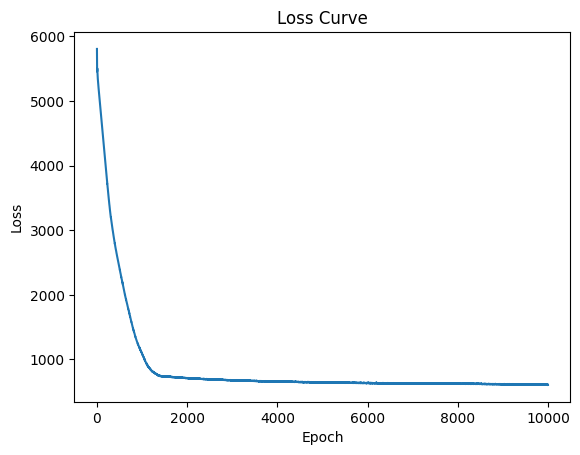

Training Accuracy: 0.7193181818181819
Training Mean Absolute Error: 0.40681818181818175
Training Mean Squared Error: 0.7568181818181817
Training Quadratic Weighted Kappa: 0.8766944830627434
Validation Accuracy: 0.5818181818181818
Validation Mean Absolute Error: 0.618181818181818
Validation Mean Squared Error: 1.1272727272727274
Validation Quadratic Weighted Kappa: 0.805337519623234
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.7168181818181818 ± 0.01354896232798988
Average Validation Accuracy: 0.6436363636363636 ± 0.04346557486502517
Average Training MAE: 0.42772727272727273 ± 0.01902314814349236
Average Validation MAE: 0.5436363636363636 ± 0.09994213201681318
Average Training MSE: 0.8350000000000002 ± 0.05112070467316545
Average Validation MSE: 1.081818181818182 ± 0.2794179310017331
Average Training Quadratic Weighted Kappa: 0.8623831087851889 ± 0.008835692450473826
Average Validation Quadratic Weighted Kappa: 0.8

In [5]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

# Assume X2, X4, X3 are defined and preprocessed data matrices

# Combine data matrices along the row axis
X = np.concatenate((X2, X4, X3), axis=0)
#print(X)

num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

# Cross-validation settings
num_folds = 5  # Define the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Initialize KFold

import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

# Listen zum Speichern der Metriken für jedes Fold
train_accuracies = []
val_accuracies = []
train_maes = []
val_maes = []
train_mses = []
val_mses = []
train_kappas = []
val_kappas = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("Cross-validation for fold: " + str(fold + 1))
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    
    # Convert input to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

    # Train the model
    model_pytorch.fit(X_train_tensor)
    
    # Make predictions on training set
    _, _, _, Xhat_tensor = model_pytorch.forward(X_train_tensor)
    Xhat_train = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

    # Training metrics
    accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
    mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
    mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
    kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')

    # Speichere Trainingsergebnisse
    train_accuracies.append(accuracy_train)
    train_maes.append(mae_train)
    train_mses.append(mse_train)
    train_kappas.append(kappa_train)

    print(f"Training Accuracy: {accuracy_train}")
    print(f"Training Mean Absolute Error: {mae_train}")
    print(f"Training Mean Squared Error: {mse_train}")
    print(f"Training Quadratic Weighted Kappa: {kappa_train}")

    # Make predictions on validation set
    _, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)
    Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

    # Validation metrics
    accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
    mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
    mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
    kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')

    # Speichere Validierungsergebnisse
    val_accuracies.append(accuracy_val)
    val_maes.append(mae_val)
    val_mses.append(mse_val)
    val_kappas.append(kappa_val)

    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation Mean Absolute Error: {mae_val}")
    print(f"Validation Mean Squared Error: {mse_val}")
    print(f"Validation Quadratic Weighted Kappa: {kappa_val}")
    
    print("-" * 50)  # Separator for each fold's results

# Am Ende der Kreuzvalidierung: Berechne die Durchschnittswerte und optional die Standardabweichungen
print("Cross-Validation Performance Summary:")

print(f"Average Training Accuracy: {np.mean(train_accuracies)} ± {np.std(train_accuracies)}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies)} ± {np.std(val_accuracies)}")

print(f"Average Training MAE: {np.mean(train_maes)} ± {np.std(train_maes)}")
print(f"Average Validation MAE: {np.mean(val_maes)} ± {np.std(val_maes)}")

print(f"Average Training MSE: {np.mean(train_mses)} ± {np.std(train_mses)}")
print(f"Average Validation MSE: {np.mean(val_mses)} ± {np.std(val_mses)}")

print(f"Average Training Quadratic Weighted Kappa: {np.mean(train_kappas)} ± {np.std(train_kappas)}")
print(f"Average Validation Quadratic Weighted Kappa: {np.mean(val_kappas)} ± {np.std(val_kappas)}")


cross val vae

Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


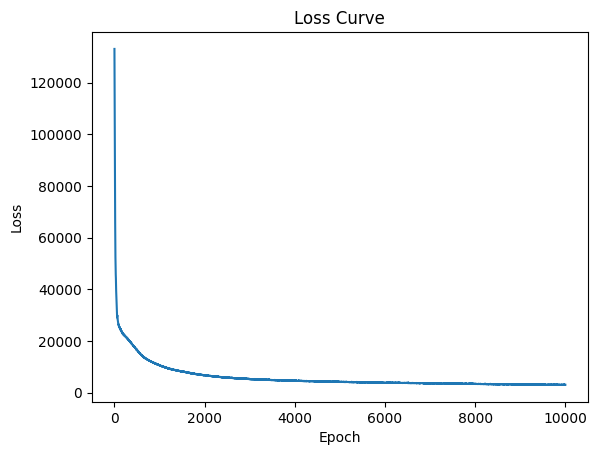

Training Accuracy: 0.9579545454545455
Training Mean Absolute Error: 0.04204545542597771
Training Mean Squared Error: 0.04204545542597771
Training Quadratic Weighted Kappa: 0.9927690529680195
Validation Accuracy: 0.6772727272727272
Validation Mean Absolute Error: 0.5
Validation Mean Squared Error: 1.045454502105713
Validation Quadratic Weighted Kappa: 0.8307828134196587
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


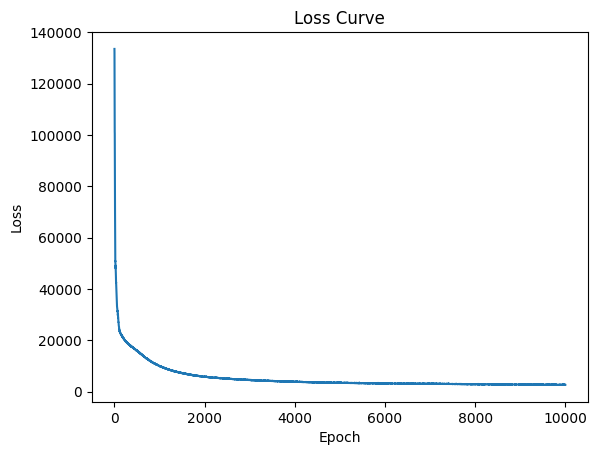

Training Accuracy: 0.9670454545454545
Training Mean Absolute Error: 0.03295454755425453
Training Mean Squared Error: 0.03295454755425453
Training Quadratic Weighted Kappa: 0.9942323147673534
Validation Accuracy: 0.7181818181818181
Validation Mean Absolute Error: 0.3954545557498932
Validation Mean Squared Error: 0.6772726774215698
Validation Quadratic Weighted Kappa: 0.8911686586985392
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


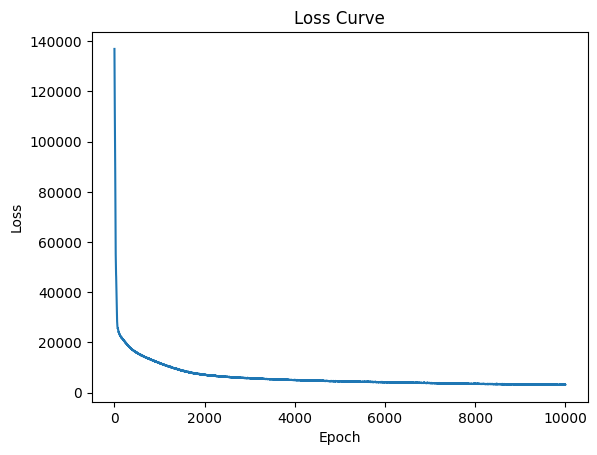

Training Accuracy: 0.9625
Training Mean Absolute Error: 0.03863636404275894
Training Mean Squared Error: 0.040909089148044586
Training Quadratic Weighted Kappa: 0.9930233295631125
Validation Accuracy: 0.6545454545454545
Validation Mean Absolute Error: 0.5727273225784302
Validation Mean Squared Error: 1.2272727489471436
Validation Quadratic Weighted Kappa: 0.7876387141059376
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


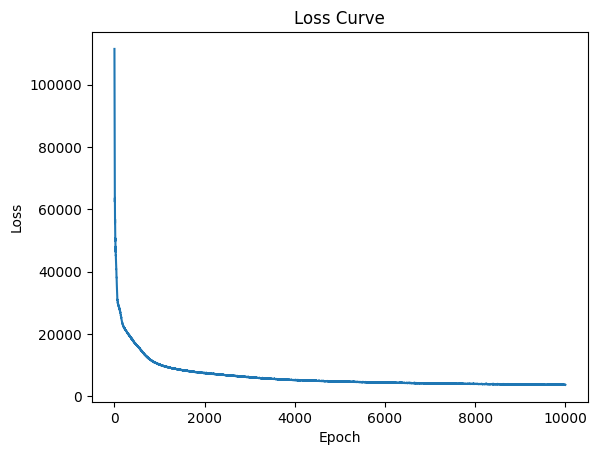

Training Accuracy: 0.9522727272727273
Training Mean Absolute Error: 0.05113636702299118
Training Mean Squared Error: 0.057954542338848114
Training Quadratic Weighted Kappa: 0.9900797334790428
Validation Accuracy: 0.6136363636363636
Validation Mean Absolute Error: 0.6363636255264282
Validation Mean Squared Error: 1.3909090757369995
Validation Quadratic Weighted Kappa: 0.7644045019317991
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_7164\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


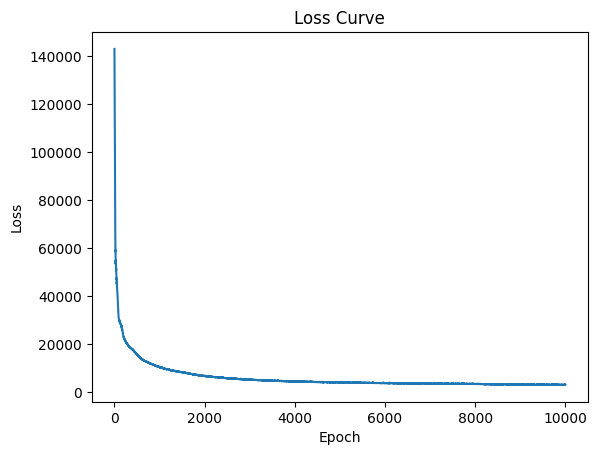

Training Accuracy: 0.9659090909090909
Training Mean Absolute Error: 0.03750000149011612
Training Mean Squared Error: 0.04431818425655365
Training Quadratic Weighted Kappa: 0.9924893314366998
Validation Accuracy: 0.6045454545454545
Validation Mean Absolute Error: 0.6090909242630005
Validation Mean Squared Error: 1.1454546451568604
Validation Quadratic Weighted Kappa: 0.8033484676503972
--------------------------------------------------
Cross-Validation Performance Summary:
Average Training Accuracy: 0.9611363636363637 ± 0.005445067523050427
Average Validation Accuracy: 0.6536363636363636 ± 0.041798414300264174
Average Training MAE: 0.040454547852277756 ± 0.006081404164433479
Average Validation MAE: 0.5427272915840149 ± 0.08670268207788467
Average Training MSE: 0.04363636299967766 ± 0.008118439465761185
Average Validation MSE: 1.0972726345062256 ± 0.2385493516921997
Average Training Quadratic Weighted Kappa: 0.9925187524428456 ± 0.0013567036054027586
Average Validation Quadratic Weighted

In [6]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

# Annahme: X2, X4, X3 sind definierte und vorverarbeitete Datenmatrizen
X = np.concatenate((X2, X4, X3), axis=0)

num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

# Cross-validation settings
num_folds = 5  # Define the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Initialize KFold

# Listen zum Speichern der Metriken für jedes Fold
train_accuracies = []
val_accuracies = []
train_maes = []
val_maes = []
train_mses = []
val_mses = []
train_kappas = []
val_kappas = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("Cross-validation for fold: " + str(fold + 1))
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    
    # Convert input to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

    # Train the model
    model_pytorch.fit(X_train_tensor)
    
    # Make predictions on training set
    _, _, _, Xhat_tensor = model_pytorch.forward(X_train_tensor)
    Xhat_train = Xhat_tensor.round().detach().numpy()

    # Training metrics
    accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
    mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
    mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
    kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')

    # Speichere Trainingsergebnisse
    train_accuracies.append(accuracy_train)
    train_maes.append(mae_train)
    train_mses.append(mse_train)
    train_kappas.append(kappa_train)

    print(f"Training Accuracy: {accuracy_train}")
    print(f"Training Mean Absolute Error: {mae_train}")
    print(f"Training Mean Squared Error: {mse_train}")
    print(f"Training Quadratic Weighted Kappa: {kappa_train}")

    # Make predictions on validation set
    _, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)
    Xhat_val = Xhat_val_tensor.round().detach().numpy()

    # Validation metrics
    accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
    mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
    mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
    kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')

    # Speichere Validierungsergebnisse
    val_accuracies.append(accuracy_val)
    val_maes.append(mae_val)
    val_mses.append(mse_val)
    val_kappas.append(kappa_val)

    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Validation Mean Absolute Error: {mae_val}")
    print(f"Validation Mean Squared Error: {mse_val}")
    print(f"Validation Quadratic Weighted Kappa: {kappa_val}")
    
    print("-" * 50)  # Separator for each fold's results

# Am Ende der Kreuzvalidierung: Berechne die Durchschnittswerte und optional die Standardabweichungen
print("Cross-Validation Performance Summary:")

print(f"Average Training Accuracy: {np.mean(train_accuracies)} ± {np.std(train_accuracies)}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies)} ± {np.std(val_accuracies)}")

print(f"Average Training MAE: {np.mean(train_maes)} ± {np.std(train_maes)}")
print(f"Average Validation MAE: {np.mean(val_maes)} ± {np.std(val_maes)}")

print(f"Average Training MSE: {np.mean(train_mses)} ± {np.std(train_mses)}")
print(f"Average Validation MSE: {np.mean(val_mses)} ± {np.std(val_mses)}")

print(f"Average Training Quadratic Weighted Kappa: {np.mean(train_kappas)} ± {np.std(train_kappas)}")
print(f"Average Validation Quadratic Weighted Kappa: {np.mean(val_kappas)} ± {np.std(val_kappas)}")


### Usability Disability Data set

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('usability-data_disability_csv.csv', skip_header=1, delimiter=',')

X = data[:, 51:61].astype(int)
X = np.delete(X, [17], axis=0)
print(X)
# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))


[[0 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 1]
 [3 0 3 0 3 1 4 0 2 0]
 [0 0 3 0 3 1 4 2 2 0]
 [3 0 4 0 4 0 4 0 4 0]
 [4 0 4 1 3 1 4 0 3 0]
 [3 1 2 4 3 1 3 1 3 4]
 [4 0 4 0 4 0 4 0 4 0]
 [1 3 0 2 0 3 2 2 1 1]
 [1 0 3 1 3 1 4 1 3 1]
 [0 2 2 4 2 2 3 2 2 0]
 [3 1 3 1 2 2 3 2 2 1]
 [4 0 2 1 1 0 4 0 3 4]
 [4 4 0 4 4 0 4 0 4 0]
 [1 2 1 3 2 2 2 3 1 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 0]
 [3 0 4 1 3 0 4 1 3 0]
 [2 2 1 3 2 2 2 3 1 4]
 [3 2 3 1 2 1 4 2 3 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 3 3 0 4 0 4 1]
 [4 0 4 2 4 0 4 0 4 4]
 [0 0 2 0 4 0 4 0 4 0]
 [4 0 4 0 3 0 4 0 4 1]
 [2 0 4 4 4 0 2 0 0 4]
 [2 0 4 3 4 3 4 2 3 1]
 [0 2 1 3 0 4 1 3 1 4]
 [2 0 1 0 1 1 2 0 4 4]
 [1 0 3 0 3 1 3 1 2 1]
 [1 3 2 0 0 2 3 2 3 2]
 [0 1 0 4 1 3 2 4 2 1]
 [1 1 3 0 2 3 3 2 3 3]
 [2 0 4 1 4 0 4 1 3 2]
 [0 0 3 3 2 1 3 2 1 1]
 [0 2 0 2 2 2 0 4 0 3]
 [0 3 2 0 3 2 4 2 2 1]
 [1 0 0 0 1 0 1 2 1 0]
 [1 0 3 0 3 0 3 0 4 1]
 [0 0 4 2 3 1 3 2 1 0]
 [2 0 3 0 3 1 4 0 3 3]
 [2 0 4 0 3 0 4 1 4 0]
 [0 1 3 0 2 1 3 1 4 0]
 [0 1 1 0 0

C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\4007003474.py:10: RuntimeWarning: invalid value encountered in cast
  X = data[:, 51:61].astype(int)


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 4748.2216796875
Epoch 100, Loss: 4026.61962890625
Epoch 200, Loss: 3521.364501953125
Epoch 300, Loss: 3101.085205078125
Epoch 400, Loss: 2732.783935546875
Epoch 500, Loss: 2406.58251953125
Epoch 600, Loss: 2085.427734375
Epoch 700, Loss: 1774.1951904296875
Epoch 800, Loss: 1518.0518798828125
Epoch 900, Loss: 1331.9747314453125
Epoch 1000, Loss: 1180.1392822265625
Epoch 1100, Loss: 1028.4578857421875
Epoch 1200, Loss: 905.0078735351562
Epoch 1300, Loss: 789.1317138671875
Epoch 1400, Loss: 700.1284790039062
Epoch 1500, Loss: 660.28662109375
Epoch 1600, Loss: 620.4217529296875
Epoch 1700, Loss: 582.1327514648438
Epoch 1800, Loss: 559.4432983398438
Epoch 1900, Loss: 556.6481323242188
Epoch 2000, Loss: 555.5633544921875
Epoch 2100, Loss: 553.5753173828125
Epoch 2200, Loss: 549.1732177734375
Epoch 2300, Loss: 546.969482421875
Epoch 2400, Loss: 546.7391357421875
Epoch 2500, Loss: 543.31982421875
Epoch 2600, Loss: 541.8955688476562
Epoch 2700, Loss: 539.5361938476562
Epoch 2800,

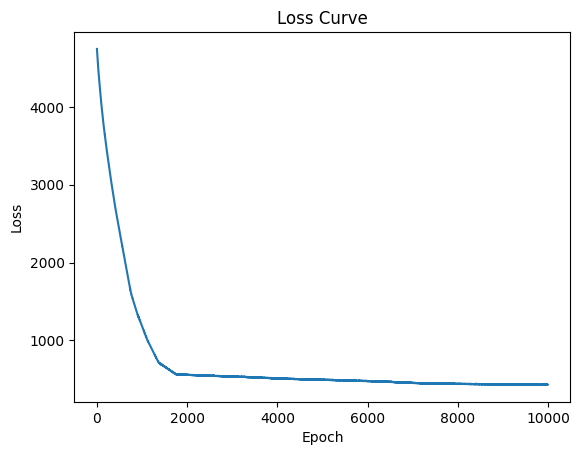

In [70]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer

num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

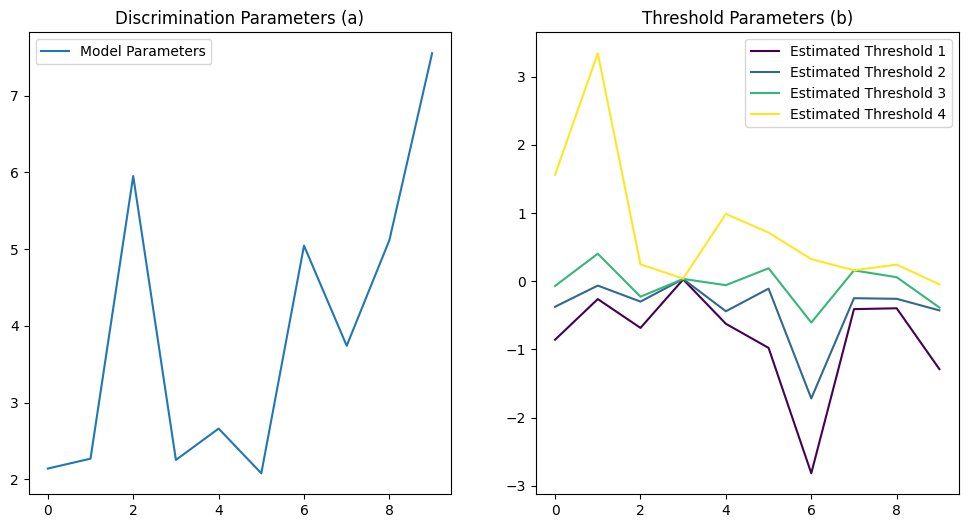

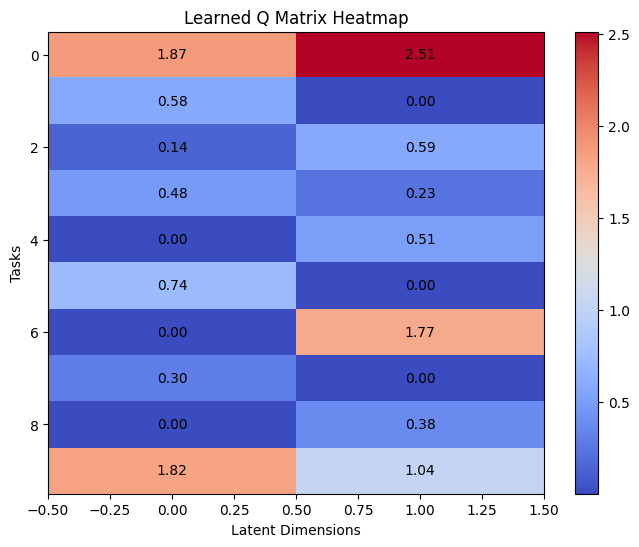

b values:
 [[-0.8579217  -0.37463668 -0.06979138  1.5596942 ]
 [-0.26239535 -0.06474973  0.40256268  3.3406413 ]
 [-0.685021   -0.29929045 -0.2273696   0.24647222]
 [ 0.02562261  0.03188446  0.03270094  0.03892825]
 [-0.6245642  -0.44089058 -0.05845969  0.9865772 ]
 [-0.97786254 -0.10942652  0.18919194  0.71186686]
 [-2.815876   -1.718765   -0.60668874  0.32307842]
 [-0.40958607 -0.24947505  0.15827072  0.16006783]
 [-0.39738703 -0.25853378  0.05828305  0.24301744]
 [-1.2891519  -0.42837277 -0.38609654 -0.04533177]]
Differences (should be non-negative):
 []
a values (should be positive):
 [2.1389456 2.2681553 5.953141  2.2512639 2.6602097 2.0775146 5.045306
 3.7399292 5.1177564 7.5536113]
Learned Q matrix:
 [[1.8674181e+00 2.5128651e+00]
 [5.7945228e-01 3.6832562e-04]
 [1.4084333e-01 5.8791459e-01]
 [4.7745973e-01 2.2950210e-01]
 [4.9652148e-04 5.0879842e-01]
 [7.3850578e-01 3.1040586e-04]
 [7.5060141e-04 1.7687559e+00]
 [3.0223569e-01 6.1009626e-04]
 [3.8596962e-05 3.7710929e-01]
 [1.

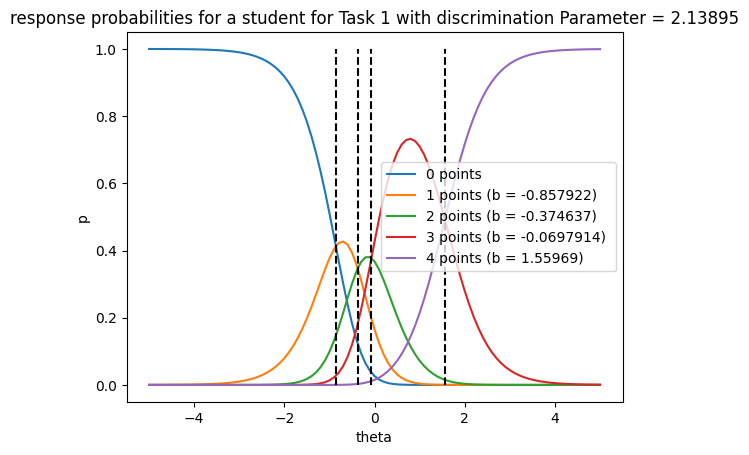

Accuracy: 0.6458333333333334
Mean Absolute Error: 0.4604166666666666
Mean Squared Error: 0.74375
Quadratic Weighted Kappa: 0.8308818304554821
Validation Accuracy: 0.5538461538461539
Validation Mean Absolute Error: 0.6538461538461539
Validation Mean Squared Error: 1.2846153846153845
Validation Quadratic Weighted Kappa: 0.711801407141909


In [71]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(a_values, label='Model Parameters')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema


# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Geschätzte Werte

#plt.plot(b_values, label='Model Parameters')
#plt.plot(B, label='True Parameters', linestyle='--')
plt.legend()

plt.show()

learned_Q = model_pytorch.Q.detach().numpy()


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



import numpy as np
import matplotlib.pyplot as plt
task = 0

theta_values = np.linspace(-5,5, 101)
bs = b_values[task,:]
a  = a_values[task] 

M = len(bs)+1
N = len(theta_values)

# compute logits
Z = np.zeros((N, M))
Z[:, 1:] = a * (np.expand_dims(theta_values, 1) - np.expand_dims(bs, 0))
Z = np.cumsum(Z, axis = 1)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 1), 1)

plt.plot(theta_values, P)
plt.xlabel('theta')
plt.ylabel('p')
plt.title(f'response probabilities for a student for Task {task + 1} with discrimination Parameter = %g' % a)
legend_entries = ['0 points ']
for j in range(M-1):
   legend_entries.append('%d points (b = %g) ' % (j+1, bs[j]))
   plt.plot([bs[j], bs[j]], [0, 1], 'k--')
plt.legend(legend_entries)
plt.show()



# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

#print(Xhat)

C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


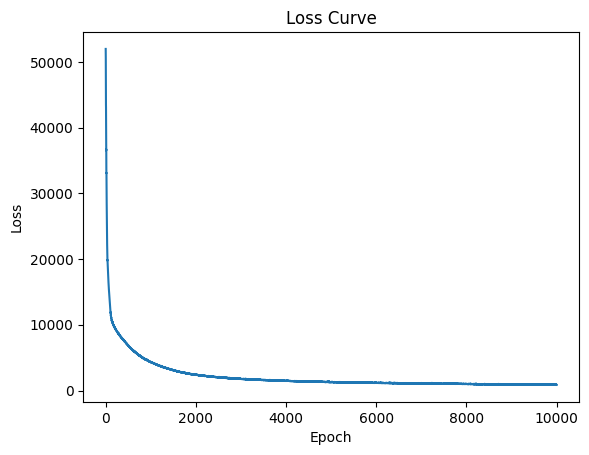

Accuracy: 0.99375
Mean Absolute Error: 0.0062500000931322575
Mean Squared Error: 0.0062500000931322575
Quadratic Weighted Kappa: 0.9985416362840892
Validation Accuracy: 0.5076923076923077
Validation Mean Absolute Error: 0.7692307829856873
Validation Mean Squared Error: 1.5230770111083984
Validation Quadratic Weighted Kappa: 0.6764705882352942


In [72]:
num_inputs = 10  # number of tasks
num_neurons = 128  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 5

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_tensor.numpy(), Xhat)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(X_tensor.numpy(), Xhat)
print(f"Mean Squared Error: {mse}")


from sklearn.metrics import cohen_kappa_score
X_tensor_flat = X_tensor.numpy().ravel()
X_hat_flat = Xhat.ravel()

# Berechne den quadratisch gewichteten Kappa
kappa = cohen_kappa_score(X_tensor_flat, X_hat_flat, weights='quadratic')
print(f"Quadratic Weighted Kappa: {kappa}")

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Validation Accuracy: {accuracy_val}")

# Mean Absolute Error for validation set
mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Absolute Error: {mae_val}")

# Mean Squared Error for validation set
mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
print(f"Validation Mean Squared Error: {mse_val}")

# Flatten the tensors for Kappa calculation
X_val_tensor_flat = X_val_tensor.numpy().ravel()
X_hat_val_flat = Xhat_val.ravel()

# Quadratic Weighted Kappa for validation set
kappa_val = cohen_kappa_score(X_val_tensor_flat, X_hat_val_flat, weights='quadratic')
print(f"Validation Quadratic Weighted Kappa: {kappa_val}")


Cross-validation for fold: 1
Epoch 0, Loss: 4524.76708984375


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3882404682.py:6: RuntimeWarning: invalid value encountered in cast
  X = data[:, 51:61].astype(int)
C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 3911.467529296875
Epoch 200, Loss: 3439.106201171875
Epoch 300, Loss: 3070.04345703125
Epoch 400, Loss: 2738.4111328125
Epoch 500, Loss: 2437.89599609375
Epoch 600, Loss: 2168.517333984375
Epoch 700, Loss: 1926.688232421875
Epoch 800, Loss: 1689.4061279296875
Epoch 900, Loss: 1464.1763916015625
Epoch 1000, Loss: 1271.5977783203125
Epoch 1100, Loss: 1116.9888916015625
Epoch 1200, Loss: 976.8956909179688
Epoch 1300, Loss: 862.8245239257812
Epoch 1400, Loss: 760.814697265625
Epoch 1500, Loss: 713.7530517578125
Epoch 1600, Loss: 672.15771484375
Epoch 1700, Loss: 627.7262573242188
Epoch 1800, Loss: 585.3876342773438
Epoch 1900, Loss: 544.3209838867188
Epoch 2000, Loss: 524.1568603515625
Epoch 2100, Loss: 520.2991943359375
Epoch 2200, Loss: 518.086669921875
Epoch 2300, Loss: 515.6675415039062
Epoch 2400, Loss: 513.29296875
Epoch 2500, Loss: 511.6897277832031
Epoch 2600, Loss: 509.45208740234375
Epoch 2700, Loss: 507.3955383300781
Epoch 2800, Loss: 505.988037109375
Epoch 2900

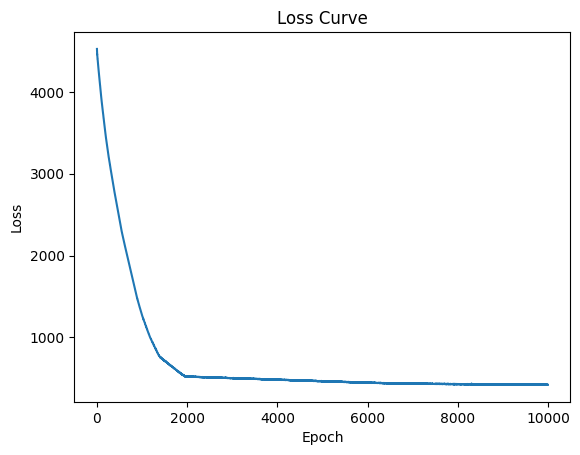

Training Accuracy: 0.6520833333333333
Training Mean Absolute Error: 0.45
Training Mean Squared Error: 0.7208333333333333
Training Quadratic Weighted Kappa: 0.835831252557723
Validation Accuracy: 0.5769230769230769
Validation Mean Absolute Error: 0.6384615384615385
Validation Mean Squared Error: 1.2846153846153845
Validation Quadratic Weighted Kappa: 0.7212020033388982
--------------------------------------------------
Cross-validation for fold: 2
Epoch 0, Loss: 5020.81689453125


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4195.529296875
Epoch 200, Loss: 3623.503662109375
Epoch 300, Loss: 3113.142333984375
Epoch 400, Loss: 2647.218017578125
Epoch 500, Loss: 2252.610107421875
Epoch 600, Loss: 1958.62890625
Epoch 700, Loss: 1723.230712890625
Epoch 800, Loss: 1568.9661865234375
Epoch 900, Loss: 1419.3887939453125
Epoch 1000, Loss: 1271.0618896484375
Epoch 1100, Loss: 1139.20068359375
Epoch 1200, Loss: 1024.452392578125
Epoch 1300, Loss: 910.5125122070312
Epoch 1400, Loss: 819.6825561523438
Epoch 1500, Loss: 746.0792236328125
Epoch 1600, Loss: 672.9844970703125
Epoch 1700, Loss: 601.0089111328125
Epoch 1800, Loss: 564.695068359375
Epoch 1900, Loss: 530.5535278320312
Epoch 2000, Loss: 523.388427734375
Epoch 2100, Loss: 518.76611328125
Epoch 2200, Loss: 513.6636352539062
Epoch 2300, Loss: 514.1777954101562
Epoch 2400, Loss: 513.5670776367188
Epoch 2500, Loss: 509.8470764160156
Epoch 2600, Loss: 510.11590576171875
Epoch 2700, Loss: 508.2989196777344
Epoch 2800, Loss: 506.5543212890625
Epoch 290

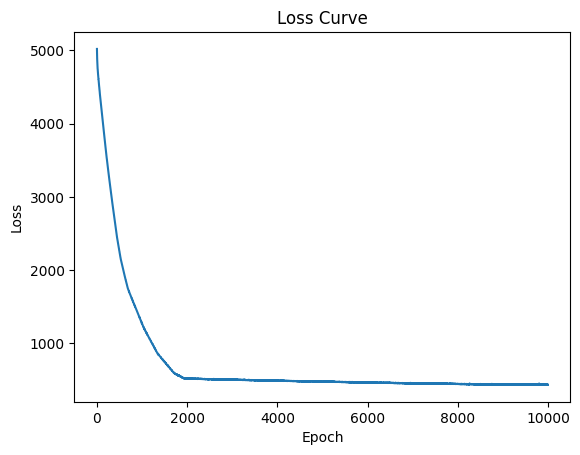

Training Accuracy: 0.6408163265306123
Training Mean Absolute Error: 0.47346938775510206
Training Mean Squared Error: 0.7755102040816326
Training Quadratic Weighted Kappa: 0.8227183316100259
Validation Accuracy: 0.5583333333333333
Validation Mean Absolute Error: 0.5916666666666666
Validation Mean Squared Error: 1.025
Validation Quadratic Weighted Kappa: 0.7622422680412371
--------------------------------------------------
Cross-validation for fold: 3
Epoch 0, Loss: 4791.29931640625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 3645.1103515625
Epoch 200, Loss: 3192.400390625
Epoch 300, Loss: 2770.484130859375
Epoch 400, Loss: 2445.6650390625
Epoch 500, Loss: 2154.870849609375
Epoch 600, Loss: 1870.2171630859375
Epoch 700, Loss: 1594.143798828125
Epoch 800, Loss: 1407.8275146484375
Epoch 900, Loss: 1252.9990234375
Epoch 1000, Loss: 1118.861083984375
Epoch 1100, Loss: 1007.2402954101562
Epoch 1200, Loss: 908.7138671875
Epoch 1300, Loss: 861.1250610351562
Epoch 1400, Loss: 822.4683837890625
Epoch 1500, Loss: 784.2901611328125
Epoch 1600, Loss: 745.2340087890625
Epoch 1700, Loss: 709.1953735351562
Epoch 1800, Loss: 670.2457275390625
Epoch 1900, Loss: 632.9771728515625
Epoch 2000, Loss: 596.4668579101562
Epoch 2100, Loss: 557.899169921875
Epoch 2200, Loss: 538.67041015625
Epoch 2300, Loss: 534.07177734375
Epoch 2400, Loss: 531.4714965820312
Epoch 2500, Loss: 530.2246704101562
Epoch 2600, Loss: 527.8928833007812
Epoch 2700, Loss: 525.7115478515625
Epoch 2800, Loss: 524.7269287109375
Epoch 2900, Los

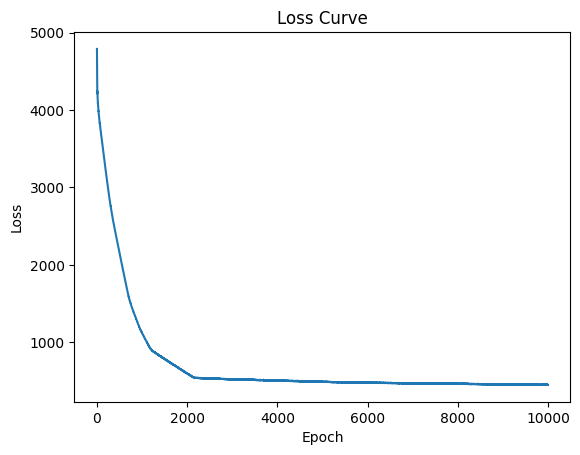

Training Accuracy: 0.6346938775510204
Training Mean Absolute Error: 0.5204081632653061
Training Mean Squared Error: 0.9530612244897959
Training Quadratic Weighted Kappa: 0.789467389204258
Validation Accuracy: 0.5083333333333333
Validation Mean Absolute Error: 0.6666666666666667
Validation Mean Squared Error: 1.15
Validation Quadratic Weighted Kappa: 0.7285601888276947
--------------------------------------------------
Cross-validation for fold: 4
Epoch 0, Loss: 4837.201171875


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 4216.701171875
Epoch 200, Loss: 3665.685546875
Epoch 300, Loss: 3215.908935546875
Epoch 400, Loss: 2841.69287109375
Epoch 500, Loss: 2500.88916015625
Epoch 600, Loss: 2226.542236328125
Epoch 700, Loss: 1985.7950439453125
Epoch 800, Loss: 1747.7633056640625
Epoch 900, Loss: 1536.242919921875
Epoch 1000, Loss: 1343.8016357421875
Epoch 1100, Loss: 1150.2646484375
Epoch 1200, Loss: 968.35107421875
Epoch 1300, Loss: 816.2367553710938
Epoch 1400, Loss: 694.2620849609375
Epoch 1500, Loss: 595.1100463867188
Epoch 1600, Loss: 562.7515869140625
Epoch 1700, Loss: 559.3507690429688
Epoch 1800, Loss: 557.3753051757812
Epoch 1900, Loss: 552.93359375
Epoch 2000, Loss: 548.8263549804688
Epoch 2100, Loss: 547.090087890625
Epoch 2200, Loss: 542.9288330078125
Epoch 2300, Loss: 541.4644775390625
Epoch 2400, Loss: 539.1370849609375
Epoch 2500, Loss: 537.4249877929688
Epoch 2600, Loss: 533.3578491210938
Epoch 2700, Loss: 532.4842529296875
Epoch 2800, Loss: 530.572998046875
Epoch 2900, Loss:

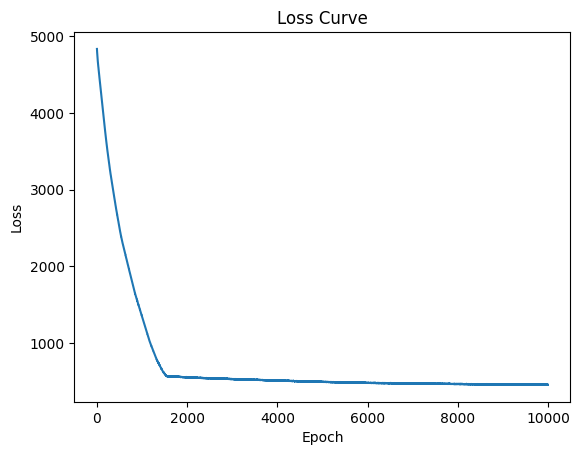

Training Accuracy: 0.6387755102040816
Training Mean Absolute Error: 0.510204081632653
Training Mean Squared Error: 0.9428571428571427
Training Quadratic Weighted Kappa: 0.7911392405063291
Validation Accuracy: 0.6166666666666667
Validation Mean Absolute Error: 0.4833333333333334
Validation Mean Squared Error: 0.7000000000000001
Validation Quadratic Weighted Kappa: 0.8408437805917832
--------------------------------------------------
Cross-validation for fold: 5
Epoch 0, Loss: 3272.53515625


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\2976920790.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 100, Loss: 2663.591796875
Epoch 200, Loss: 2230.946044921875
Epoch 300, Loss: 1916.696533203125
Epoch 400, Loss: 1639.2672119140625
Epoch 500, Loss: 1380.7196044921875
Epoch 600, Loss: 1201.9432373046875
Epoch 700, Loss: 1047.8018798828125
Epoch 800, Loss: 922.867431640625
Epoch 900, Loss: 801.4469604492188
Epoch 1000, Loss: 682.2284545898438
Epoch 1100, Loss: 613.1602783203125
Epoch 1200, Loss: 606.282958984375
Epoch 1300, Loss: 601.0023193359375
Epoch 1400, Loss: 597.4810180664062
Epoch 1500, Loss: 593.2446899414062
Epoch 1600, Loss: 589.8466186523438
Epoch 1700, Loss: 586.2400512695312
Epoch 1800, Loss: 582.5357666015625
Epoch 1900, Loss: 579.4124755859375
Epoch 2000, Loss: 574.9716186523438
Epoch 2100, Loss: 571.2616577148438
Epoch 2200, Loss: 567.6400756835938
Epoch 2300, Loss: 562.9795532226562
Epoch 2400, Loss: 559.8018798828125
Epoch 2500, Loss: 556.4319458007812
Epoch 2600, Loss: 553.506103515625
Epoch 2700, Loss: 551.1683959960938
Epoch 2800, Loss: 549.3485717773438
Epo

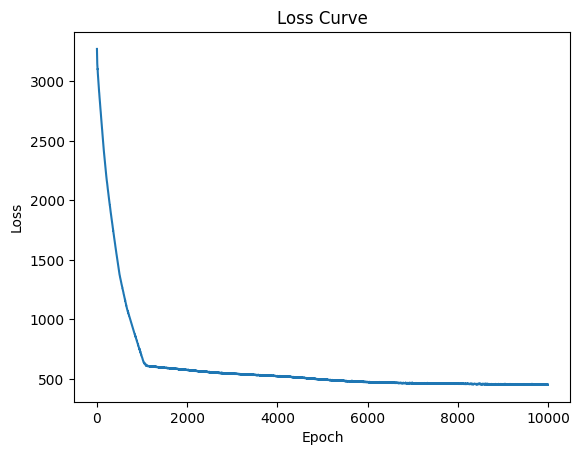

Training Accuracy: 0.6489795918367347
Training Mean Absolute Error: 0.5408163265306123
Training Mean Squared Error: 1.1081632653061224
Training Quadratic Weighted Kappa: 0.7569360069428585
Validation Accuracy: 0.575
Validation Mean Absolute Error: 0.7083333333333334
Validation Mean Squared Error: 1.5750000000000002
Validation Quadratic Weighted Kappa: 0.684526790185278
--------------------------------------------------


In [73]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[:, 51:61].astype(int)
X = np.delete(X, [17], axis=0)

# Cross-validation settings
num_folds = 5  # Define the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Initialize KFold

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("Cross-validation for fold: " + str(fold + 1))
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    
    # Convert input to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

    # Train the model
    model_pytorch.fit(X_train_tensor)
    
    # Make predictions on training set
    _, _, _, Xhat_tensor = model_pytorch.forward(X_train_tensor)
    Xhat_train = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

    # Calculate accuracy on training set
    accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
    print(f"Training Accuracy: {accuracy_train}")

    # Mean Absolute Error on training set
    mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
    print(f"Training Mean Absolute Error: {mae_train}")

    # Mean Squared Error on training set
    mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
    print(f"Training Mean Squared Error: {mse_train}")

    # Quadratic Weighted Kappa on training set
    kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')
    print(f"Training Quadratic Weighted Kappa: {kappa_train}")

    # Make predictions on validation set
    _, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)
    Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

    # Calculate accuracy on validation set
    accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
    print(f"Validation Accuracy: {accuracy_val}")

    # Mean Absolute Error on validation set
    mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
    print(f"Validation Mean Absolute Error: {mae_val}")

    # Mean Squared Error on validation set
    mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
    print(f"Validation Mean Squared Error: {mse_val}")

    # Quadratic Weighted Kappa on validation set
    kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')
    print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

    print("-" * 50)  # Separator for each fold's results


Cross-validation for fold: 1


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3392892775.py:6: RuntimeWarning: invalid value encountered in cast
  X = data[:, 51:61].astype(int)
C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


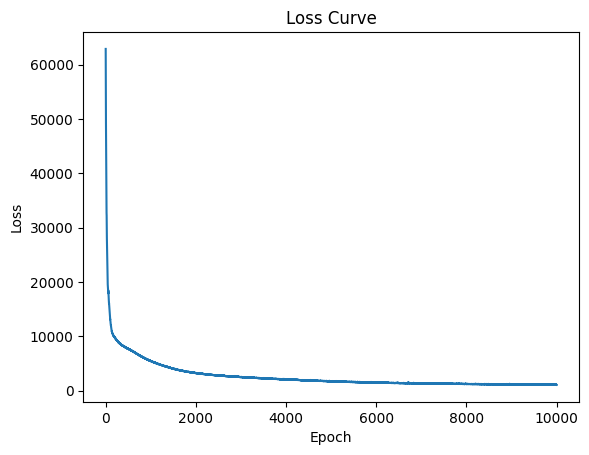

Training Accuracy: 0.9895833333333334
Training Mean Absolute Error: 0.010416666977107525
Training Mean Squared Error: 0.010416666977107525
Training Quadratic Weighted Kappa: 0.997576462604818
Validation Accuracy: 0.4461538461538462
Validation Mean Absolute Error: 0.7923077344894409
Validation Mean Squared Error: 1.4538462162017822
Validation Quadratic Weighted Kappa: 0.6916802610114192
--------------------------------------------------
Cross-validation for fold: 2


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


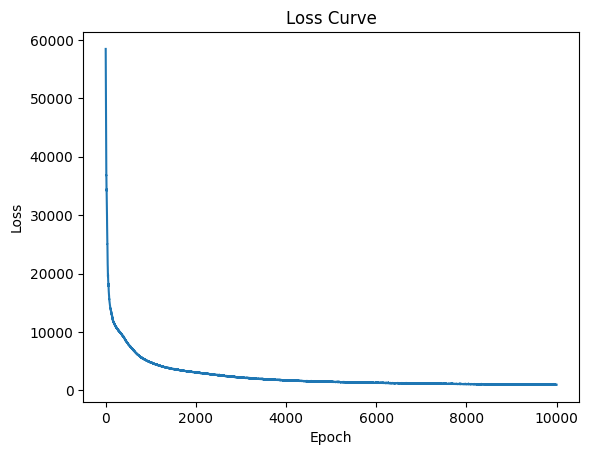

Training Accuracy: 0.9918367346938776
Training Mean Absolute Error: 0.008163264952600002
Training Mean Squared Error: 0.008163264952600002
Training Quadratic Weighted Kappa: 0.9981318067525654
Validation Accuracy: 0.45
Validation Mean Absolute Error: 0.824999988079071
Validation Mean Squared Error: 1.5916666984558105
Validation Quadratic Weighted Kappa: 0.6656942823803967
--------------------------------------------------
Cross-validation for fold: 3


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


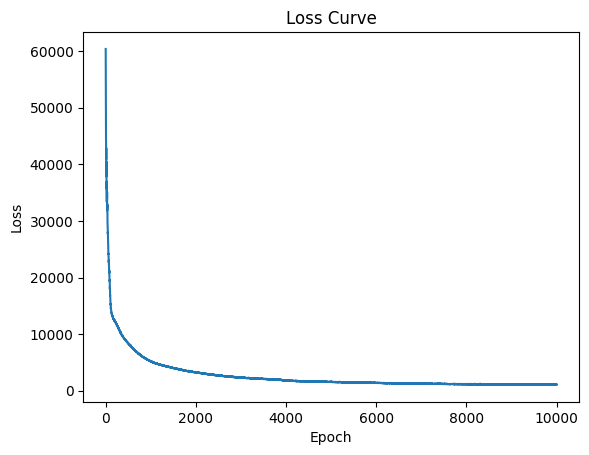

Training Accuracy: 0.9897959183673469
Training Mean Absolute Error: 0.010204081423580647
Training Mean Squared Error: 0.010204081423580647
Training Quadratic Weighted Kappa: 0.9976956141423452
Validation Accuracy: 0.425
Validation Mean Absolute Error: 0.7250000238418579
Validation Mean Squared Error: 1.0750000476837158
Validation Quadratic Weighted Kappa: 0.736088379705401
--------------------------------------------------
Cross-validation for fold: 4


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


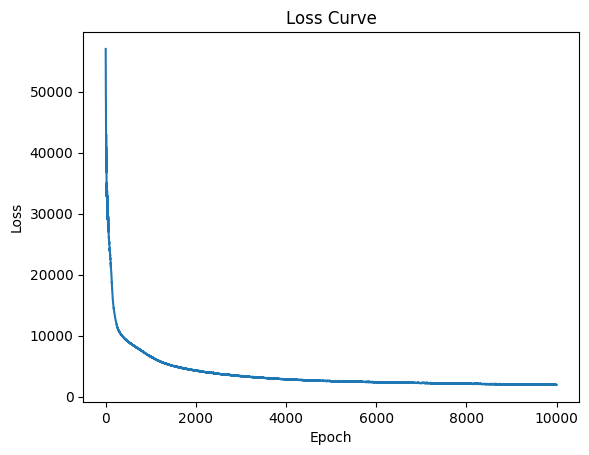

Training Accuracy: 0.9857142857142858
Training Mean Absolute Error: 0.020408162847161293
Training Mean Squared Error: 0.04489796236157417
Training Quadratic Weighted Kappa: 0.9897823779193206
Validation Accuracy: 0.475
Validation Mean Absolute Error: 0.6833332777023315
Validation Mean Squared Error: 1.0833332538604736
Validation Quadratic Weighted Kappa: 0.742514772389661
--------------------------------------------------
Cross-validation for fold: 5


C:\Users\wuepp\AppData\Local\Temp\ipykernel_14508\3702903398.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


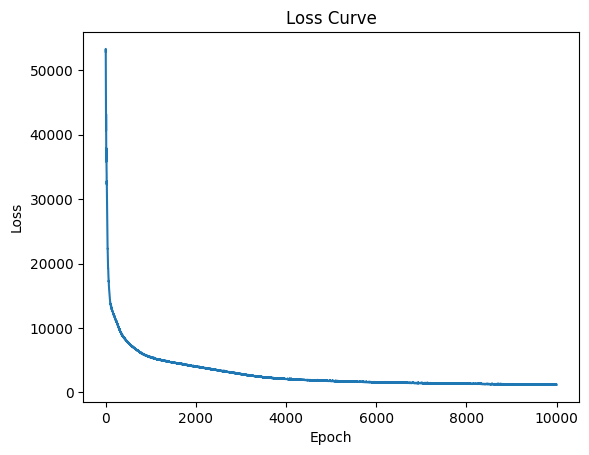

Training Accuracy: 0.9795918367346939
Training Mean Absolute Error: 0.020408162847161293
Training Mean Squared Error: 0.020408162847161293
Training Quadratic Weighted Kappa: 0.9952521496134862
Validation Accuracy: 0.475
Validation Mean Absolute Error: 0.85833340883255
Validation Mean Squared Error: 1.7916667461395264
Validation Quadratic Weighted Kappa: 0.6329178760457572
--------------------------------------------------


In [74]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score

X = data[:, 51:61].astype(int)
X = np.delete(X, [17], axis=0)

# Cross-validation settings
num_folds = 5  # Define the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # Initialize KFold

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("Cross-validation for fold: " + str(fold + 1))
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    
    # Convert input to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=5)

    # Train the model
    model_pytorch.fit(X_train_tensor)
    
    # Make predictions on training set
    _, _, _, Xhat_tensor = model_pytorch.forward(X_train_tensor)
    Xhat_train = Xhat_tensor.round().detach().numpy()

    # Calculate accuracy on training set
    accuracy_train = np.mean(X_train_tensor.numpy() == Xhat_train)
    print(f"Training Accuracy: {accuracy_train}")

    # Mean Absolute Error on training set
    mae_train = mean_absolute_error(X_train_tensor.numpy(), Xhat_train)
    print(f"Training Mean Absolute Error: {mae_train}")

    # Mean Squared Error on training set
    mse_train = mean_squared_error(X_train_tensor.numpy(), Xhat_train)
    print(f"Training Mean Squared Error: {mse_train}")

    # Quadratic Weighted Kappa on training set
    kappa_train = cohen_kappa_score(X_train_tensor.numpy().ravel(), Xhat_train.ravel(), weights='quadratic')
    print(f"Training Quadratic Weighted Kappa: {kappa_train}")

    # Make predictions on validation set
    _, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)
    Xhat_val = Xhat_val_tensor.round().detach().numpy()

    # Calculate accuracy on validation set
    accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
    print(f"Validation Accuracy: {accuracy_val}")

    # Mean Absolute Error on validation set
    mae_val = mean_absolute_error(X_val_tensor.numpy(), Xhat_val)
    print(f"Validation Mean Absolute Error: {mae_val}")

    # Mean Squared Error on validation set
    mse_val = mean_squared_error(X_val_tensor.numpy(), Xhat_val)
    print(f"Validation Mean Squared Error: {mse_val}")

    # Quadratic Weighted Kappa on validation set
    kappa_val = cohen_kappa_score(X_val_tensor.numpy().ravel(), Xhat_val.ravel(), weights='quadratic')
    print(f"Validation Quadratic Weighted Kappa: {kappa_val}")

    print("-" * 50)  # Separator for each fold's results
